## Analysis Workflow

The analysis proceeds through six systematic steps, each handling a specific aspect of performance evaluation:

1. **Loading Results**: Extract metrics from `results.json` or model-specific files
2. **DuckDB Query**: Fast SQL-based retrieval of fold-wise metrics
3. **MLflow Integration**: Load experiment tracking data (if available)
4. **Training Curves**: Extract epoch-wise or iteration-wise metrics from all folds
5. **Visualizations**: Generate comprehensive plots and charts
6. **Performance Summary**: Display detailed metrics breakdown

Each step is independent, allowing partial analysis even if some data sources are unavailable.


## Imports and Configuration

### Standard Library Imports

Essential Python standard library modules for file I/O, path manipulation, type hints, and system operations.

In [1]:
import json
import sys
from pathlib import Path
from typing import Dict, List, Optional, Any
import warnings

### Project Root Path Setup

In [2]:
# Resolve project root by searching for lib/ directory
project_root = Path.cwd()
for _ in range(10):
    if (project_root / 'lib').exists() and (project_root / 'lib' / '__init__.py').exists():
        break
    parent = project_root.parent
    if parent == project_root:
        break
    project_root = parent

# Add paths to sys.path
sys.path.insert(0, str(project_root))
sys.path.insert(0, str(project_root / "src" / "notebooks"))

# Verify notebook_utils can be imported
try:
    import notebook_utils
    print(f"✓ Project root: {project_root}")
    print(f"✓ notebook_utils found at: {notebook_utils.__file__}")
except ImportError as e:
    print(f"⚠ Warning: {e}")
    print(f"Project root: {project_root}")
    print(f"Looking for: {project_root / 'src' / 'notebooks' / 'notebook_utils.py'}")


✓ Project root: /Users/santoshdesai/Downloads/fvc
✓ notebook_utils found at: /Users/santoshdesai/Downloads/fvc/src/notebooks/notebook_utils.py


### Third-Party Library Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Plotting Configuration

In [4]:
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

### Project-Specific Utilities Import

In [5]:
try:
    from notebook_utils import (
        get_model_data_path, load_results_json, load_mlflow_metrics_by_model_type,
        query_duckdb_metrics, plot_training_curves, find_roc_pr_curve_files,
        display_roc_pr_curve_images, plot_validation_metrics_across_folds,
        MODEL_TYPE_MAPPING
    )
except ImportError as e:
    print(f"[ERROR] Failed to import notebook_utils: {e}")
    sys.exit(1)

### Project Root Detection Function

In [6]:
def get_project_root() -> Path:
    """Find project root directory."""
    current = Path.cwd()
    for _ in range(10):
        if (current / "lib").exists() and (current / "lib" / "__init__.py").exists():
            return current
        parent = current.parent
        if parent == current:
            break
        current = parent
    return Path.cwd()


### Initialize Project Root

In [7]:
PROJECT_ROOT = get_project_root()
print(f"Project root: {PROJECT_ROOT}")

Project root: /Users/santoshdesai/Downloads/fvc


## Analysis Workflow

The analysis proceeds through six systematic steps, each handling a specific aspect of performance evaluation:

1. **Loading Results**: Extract metrics from `results.json` or model-specific files
2. **DuckDB Query**: Fast SQL-based retrieval of fold-wise metrics
3. **MLflow Integration**: Load experiment tracking data (if available)
4. **Training Curves**: Extract epoch-wise or iteration-wise metrics from all folds
5. **Visualizations**: Generate comprehensive plots and charts
6. **Performance Summary**: Display detailed metrics breakdown

Each step is independent, allowing partial analysis even if some data sources are unavailable.


### Step 1/6: Loading Results from results.json

Load cross-validation results and aggregated metrics from results.json.

In [8]:
# Initialize analysis variables
project_root = get_project_root()
model_id = "5b"
model_name = "SVM"
print("=" * 70)
print("SVM (5b) - Comprehensive Performance Analysis")
print("=" * 70)
print()

SVM (5b) - Comprehensive Performance Analysis



In [9]:
print("[1/6] Loading results.json...")
model_path = get_model_data_path(model_id, project_root, MODEL_TYPE_MAPPING)
if not model_path:
    print(f"[ERROR] Model path not found for {model_id}")
    
results = load_results_json(model_id, project_root, MODEL_TYPE_MAPPING)
if results:
    print(f"  ✓ Loaded results.json")
    if "fold_results" in results:
        print(f"    - {len(results['fold_results'])} fold results")
    if "avg_val_f1" in results:
        print(f"    - Average Val F1: {results['avg_val_f1']:.4f} ± {results.get('std_val_f1', 0):.4f}")
else:
    print(f"  [WARN] No results.json found")
    results = {}

[1/6] Loading results.json...
  ✓ Loaded results.json
    - 5 fold results
    - Average Val F1: 0.6319 ± 0.0265


### Step 2/6: Querying DuckDB for Fold-wise Metrics

In [10]:
print("\n[2/6] Querying DuckDB for fold-wise metrics...")
duckdb_metrics = query_duckdb_metrics(model_id, project_root, MODEL_TYPE_MAPPING)
if duckdb_metrics:
    print(f"  ✓ Retrieved DuckDB metrics")
    
    # Display fold results summary
    if "fold_results" in duckdb_metrics:
        fold_results = duckdb_metrics["fold_results"]
        print(f"    - {len(fold_results)} fold results")
        
        # Calculate min/max across folds
        if fold_results:
            val_f1_values = [f.get('val_f1', 0) for f in fold_results if f.get('val_f1') is not None]
            val_acc_values = [f.get('val_acc', 0) for f in fold_results if f.get('val_acc') is not None]
            val_prec_values = [f.get('val_precision', 0) for f in fold_results if f.get('val_precision') is not None]
            val_recall_values = [f.get('val_recall', 0) for f in fold_results if f.get('val_recall') is not None]
            
            if val_f1_values:
                print(f"    - F1 Score:     min={min(val_f1_values):.4f}, max={max(val_f1_values):.4f}")
            if val_acc_values:
                print(f"    - Accuracy:     min={min(val_acc_values):.4f}, max={max(val_acc_values):.4f}")
            if val_prec_values:
                print(f"    - Precision:    min={min(val_prec_values):.4f}, max={max(val_prec_values):.4f}")
            if val_recall_values:
                print(f"    - Recall:       min={min(val_recall_values):.4f}, max={max(val_recall_values):.4f}")
    
    # Display aggregated metrics
    if "aggregated" in duckdb_metrics:
        agg = duckdb_metrics["aggregated"]
        print(f"\n    Aggregated Metrics (Mean ± Std):")
        if agg.get('mean_val_f1') is not None:
            print(f"      F1 Score:     {agg.get('mean_val_f1', 0):.4f} ± {agg.get('std_val_f1', 0):.4f}")
        if agg.get('mean_val_acc') is not None:
            print(f"      Accuracy:     {agg.get('mean_val_acc', 0):.4f} ± {agg.get('std_val_acc', 0):.4f}")
        if agg.get('mean_val_precision') is not None:
            print(f"      Precision:    {agg.get('mean_val_precision', 0):.4f} ± {agg.get('std_val_precision', 0):.4f}")
        if agg.get('mean_val_recall') is not None:
            print(f"      Recall:       {agg.get('mean_val_recall', 0):.4f} ± {agg.get('std_val_recall', 0):.4f}")
        
        # Display per-class metrics if available
        if fold_results and any('val_f1_class0' in f or 'val_f1_class1' in f for f in fold_results):
            class0_f1 = [f.get('val_f1_class0') for f in fold_results if f.get('val_f1_class0') is not None]
            class1_f1 = [f.get('val_f1_class1') for f in fold_results if f.get('val_f1_class1') is not None]
            if class0_f1:
                print(f"      Class 0 F1:    {np.mean(class0_f1):.4f} ± {np.std(class0_f1):.4f}")
            if class1_f1:
                print(f"      Class 1 F1:    {np.mean(class1_f1):.4f} ± {np.std(class1_f1):.4f}")
else:
    print(f"  [WARN] No DuckDB metrics found")
    duckdb_metrics = {}



[2/6] Querying DuckDB for fold-wise metrics...
  ✓ Retrieved DuckDB metrics
    - 70 fold results
    - F1 Score:     min=0.5333, max=0.7297
    - Accuracy:     min=0.5758, max=0.6970
    - Precision:    min=0.5804, max=0.6750
    - Recall:       min=0.4706, max=0.7941

    Aggregated Metrics (Mean ± Std):
      F1 Score:     0.6525 ± 0.0644
      Accuracy:     0.6372 ± 0.0402
      Precision:    0.6335 ± 0.0233
      Recall:       0.6802 ± 0.1106
      Class 0 F1:    0.6156 ± 0.0236
      Class 1 F1:    0.6525 ± 0.0639


### Step 3/6: Loading MLflow Tracking Data

Note: Baseline models don't use MLflow tracking.

In [11]:
print("\n[3/6] Loading MLflow tracking data...")
model_type = MODEL_TYPE_MAPPING.get(model_id)
if model_type:
    mlflow_data = load_mlflow_metrics_by_model_type(model_type, "mlruns/", project_root)
    if mlflow_data and isinstance(mlflow_data, dict) and "message" not in mlflow_data:
        print(f"  ✓ Loaded MLflow data")
    else:
        print(f"  [INFO] Baseline models don't use MLflow tracking")
else:
    mlflow_data = {}


[3/6] Loading MLflow tracking data...
  [INFO] Baseline models don't use MLflow tracking


### Step 4/6: Extracting Training Curves from metrics.jsonl

SVM models log final validation metrics to metrics.jsonl but don't have epoch-wise training data.


[4/6] Extracting training curves from metrics.jsonl...
  ✓ Found 5 fold directories
    Processing fold_1...


      ✓ Generated training curves plot for fold_1


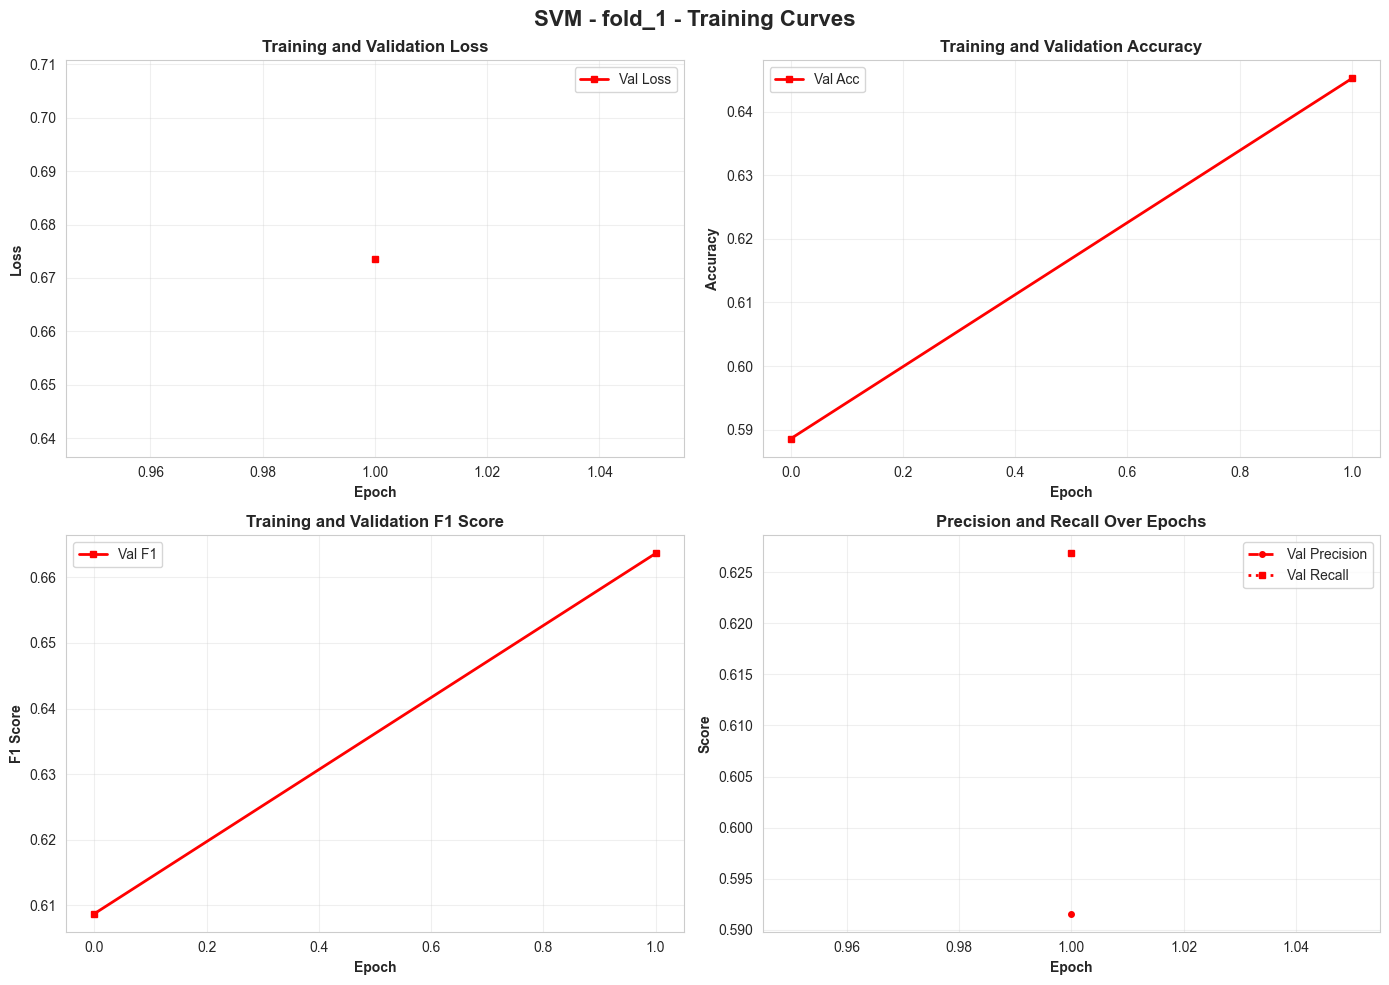

    Processing fold_2...


      ✓ Generated training curves plot for fold_2


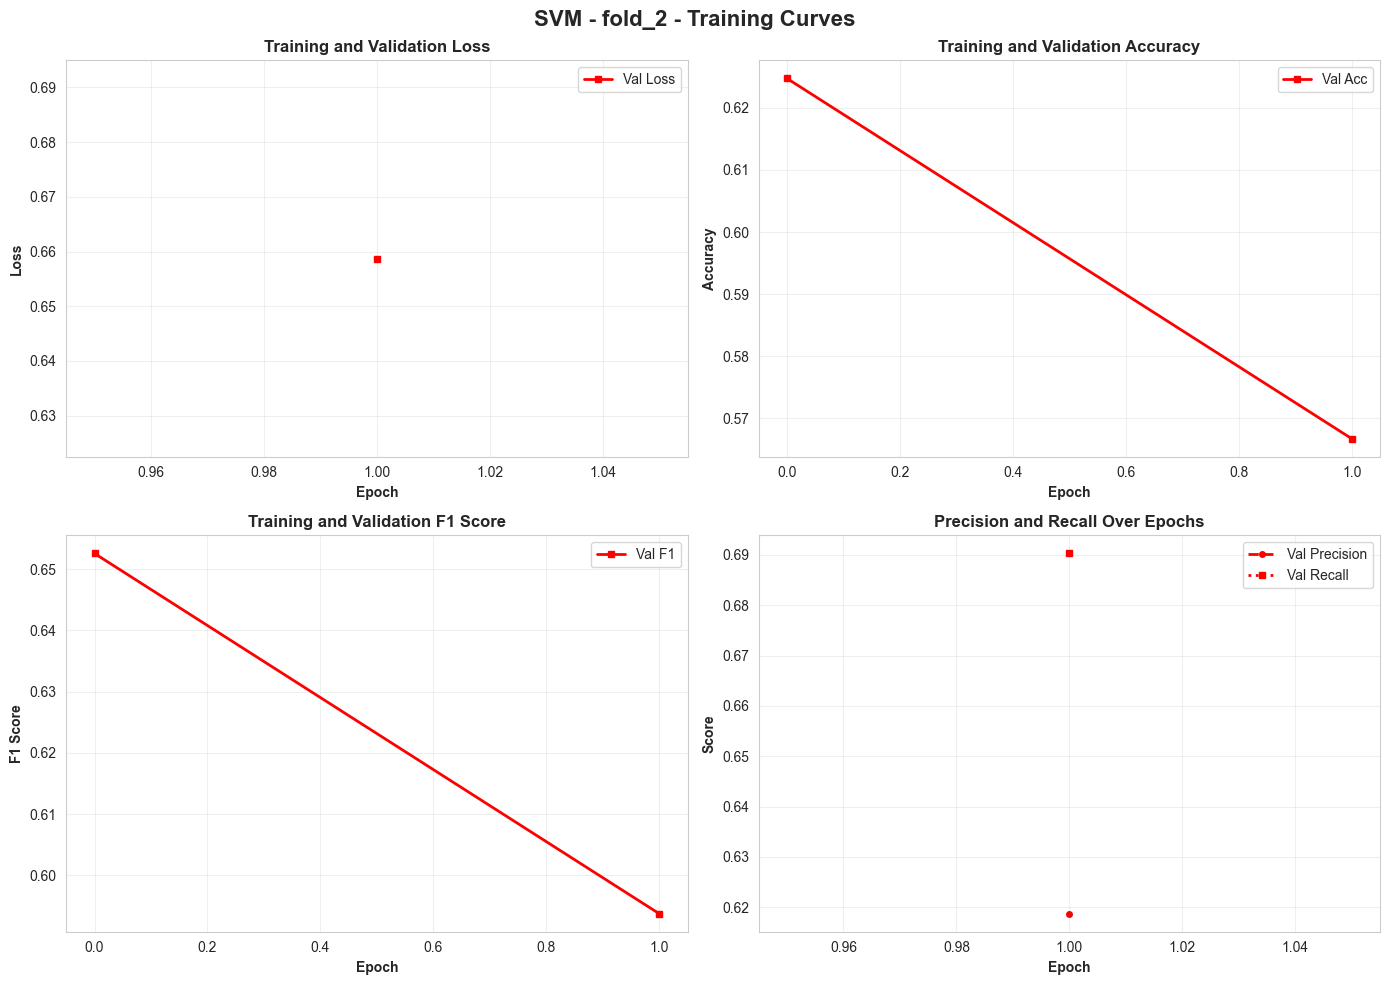

    Processing fold_3...
      ✓ Generated training curves plot for fold_3


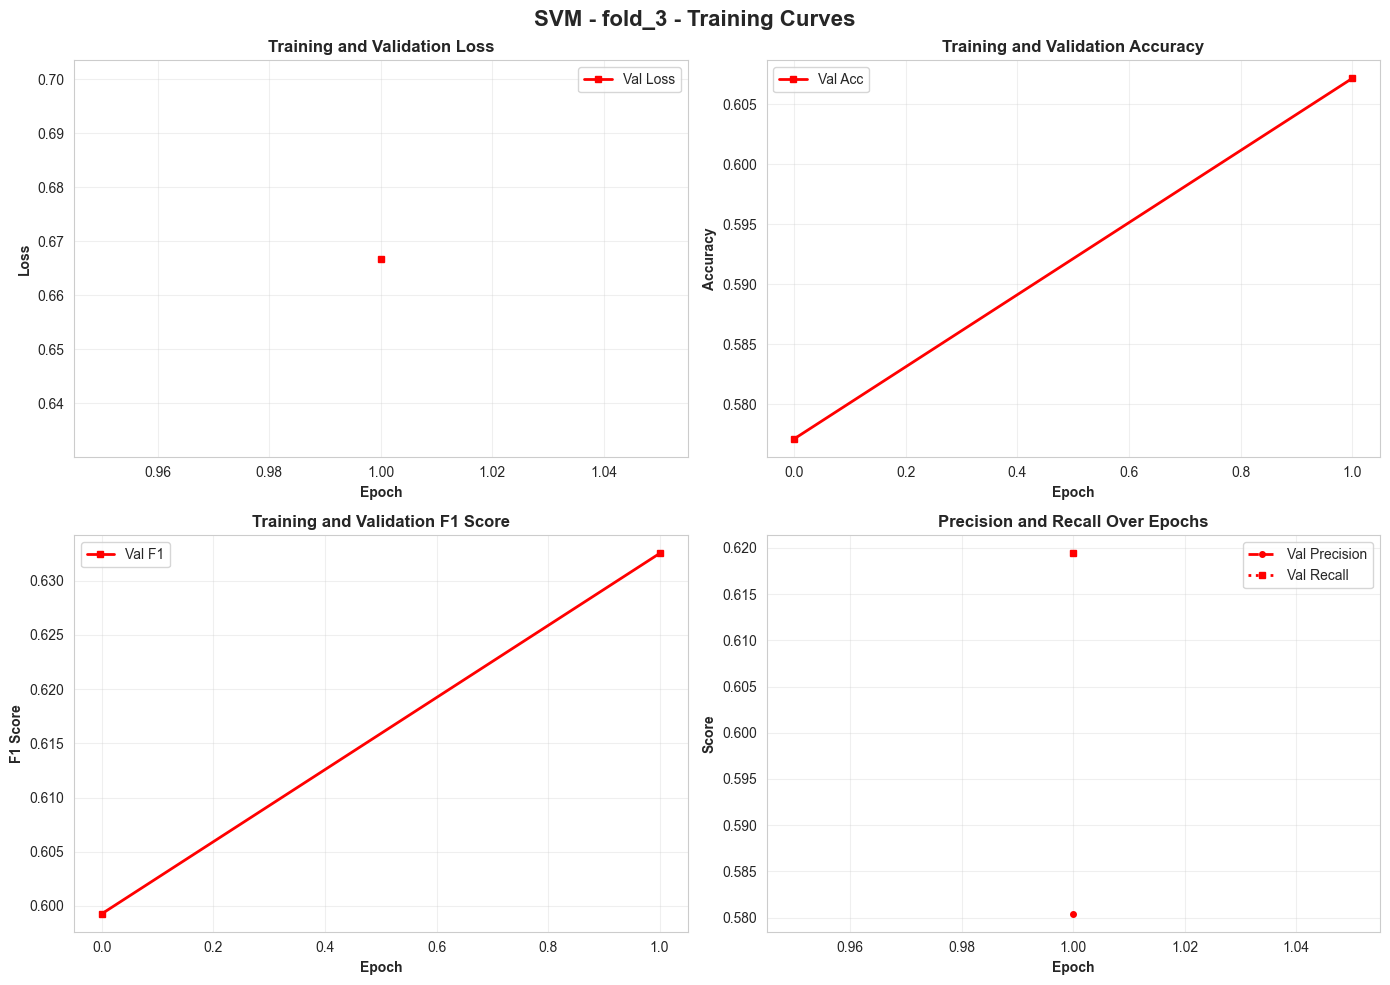

    Processing fold_4...
      ✓ Generated training curves plot for fold_4


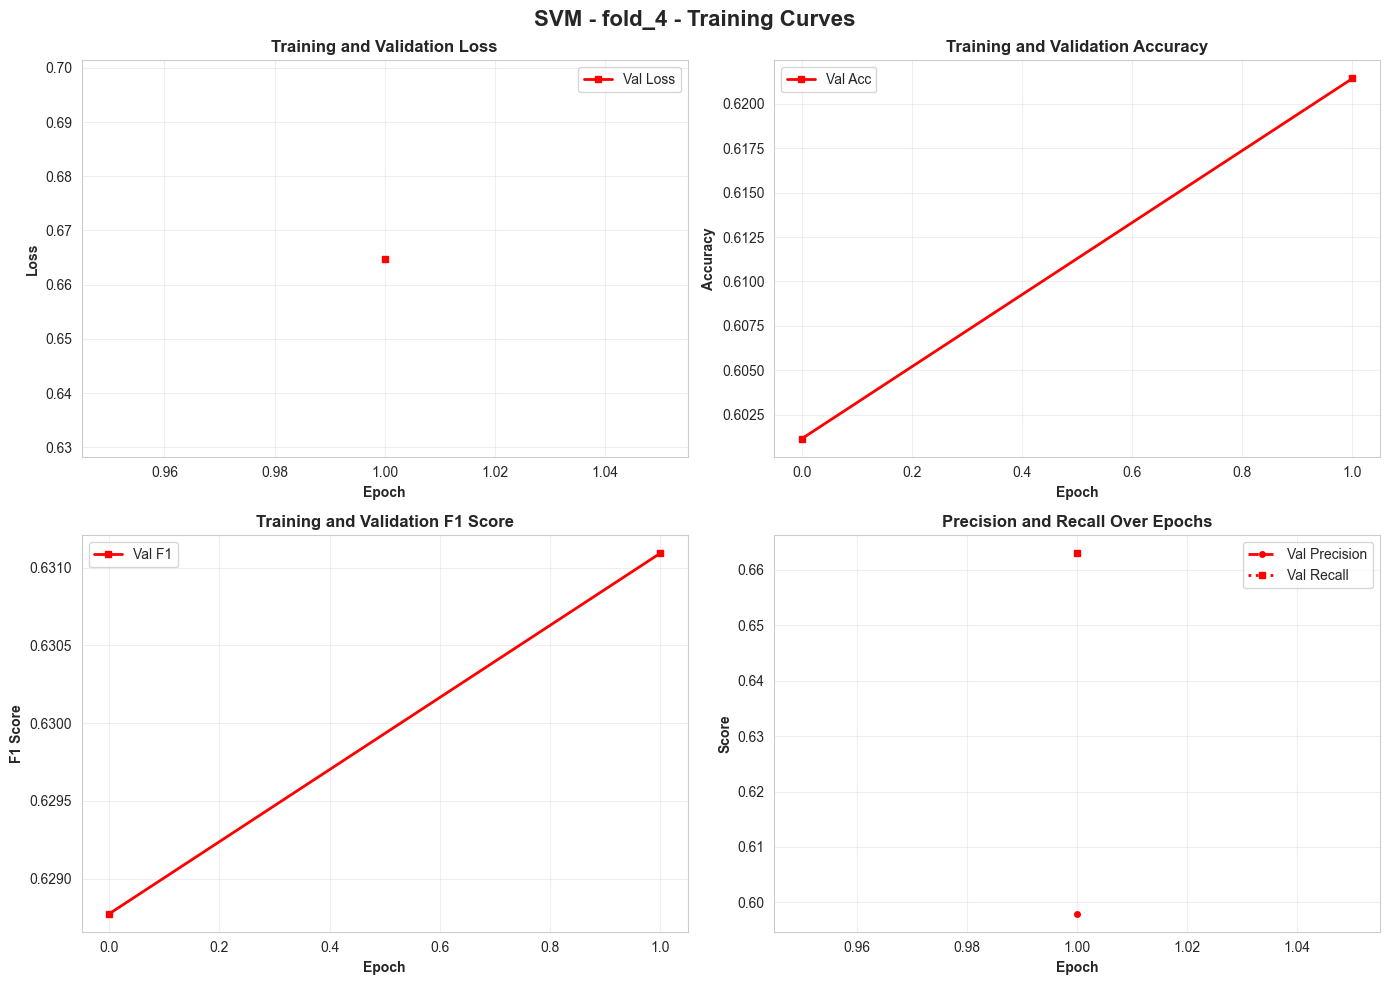

    Processing fold_5...


      ✓ Generated training curves plot for fold_5


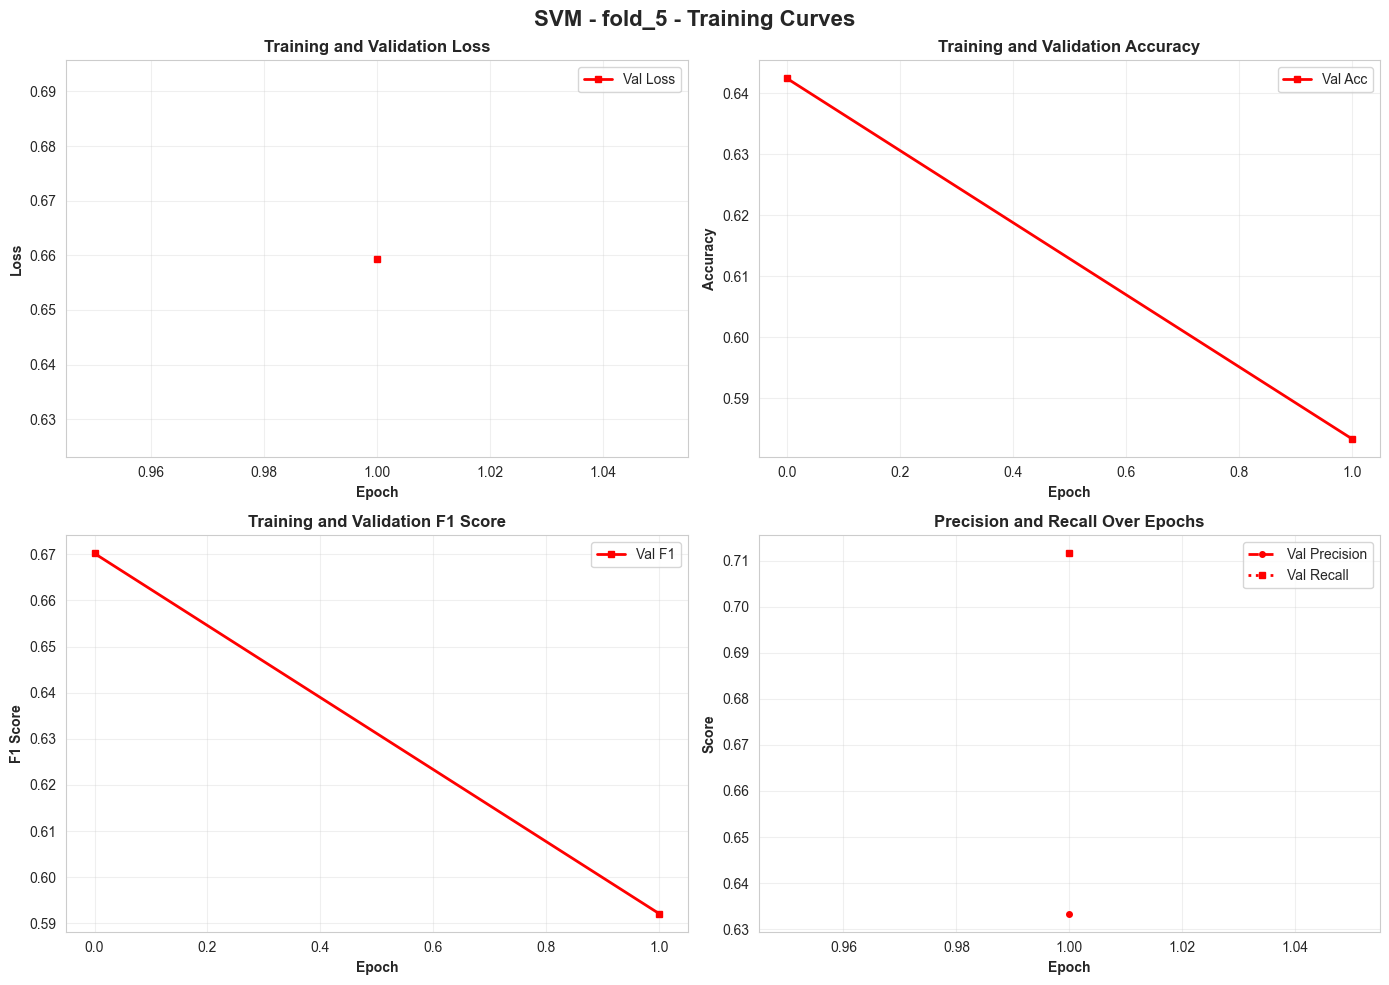

  ✓ Generated 5 training curve plot(s) across all folds


In [12]:
print("\n[4/6] Extracting training curves from metrics.jsonl...")
fold_dirs = sorted(model_path.glob("fold_*"))
if fold_dirs:
    print(f"  ✓ Found {len(fold_dirs)} fold directories")
    
    # Process all folds, not just the first one
    plots_generated = 0
    for fold_dir in fold_dirs:
        metrics_file = fold_dir / "metrics.jsonl"
        if metrics_file.exists():
            print(f"    Processing {fold_dir.name}...")
            fig = plot_training_curves(metrics_file, f"{model_name} - {fold_dir.name}")
            if fig:
                print(f"      ✓ Generated training curves plot for {fold_dir.name}")
                plt.show()  # Display the plot in notebook
                plots_generated += 1
            else:
                print(f"      [INFO] No epoch-by-epoch training data in {fold_dir.name}")
    
    if plots_generated == 0:
        print(f"  [WARN] No training curves generated from any fold")
    else:
        print(f"  ✓ Generated {plots_generated} training curve plot(s) across all folds")
else:
    print(f"  [WARN] No fold directories found")


### Step 5/6: Generating Comprehensive Visualizations


[5/6] Generating comprehensive visualizations...
  ✓ Found ROC/PR curve files


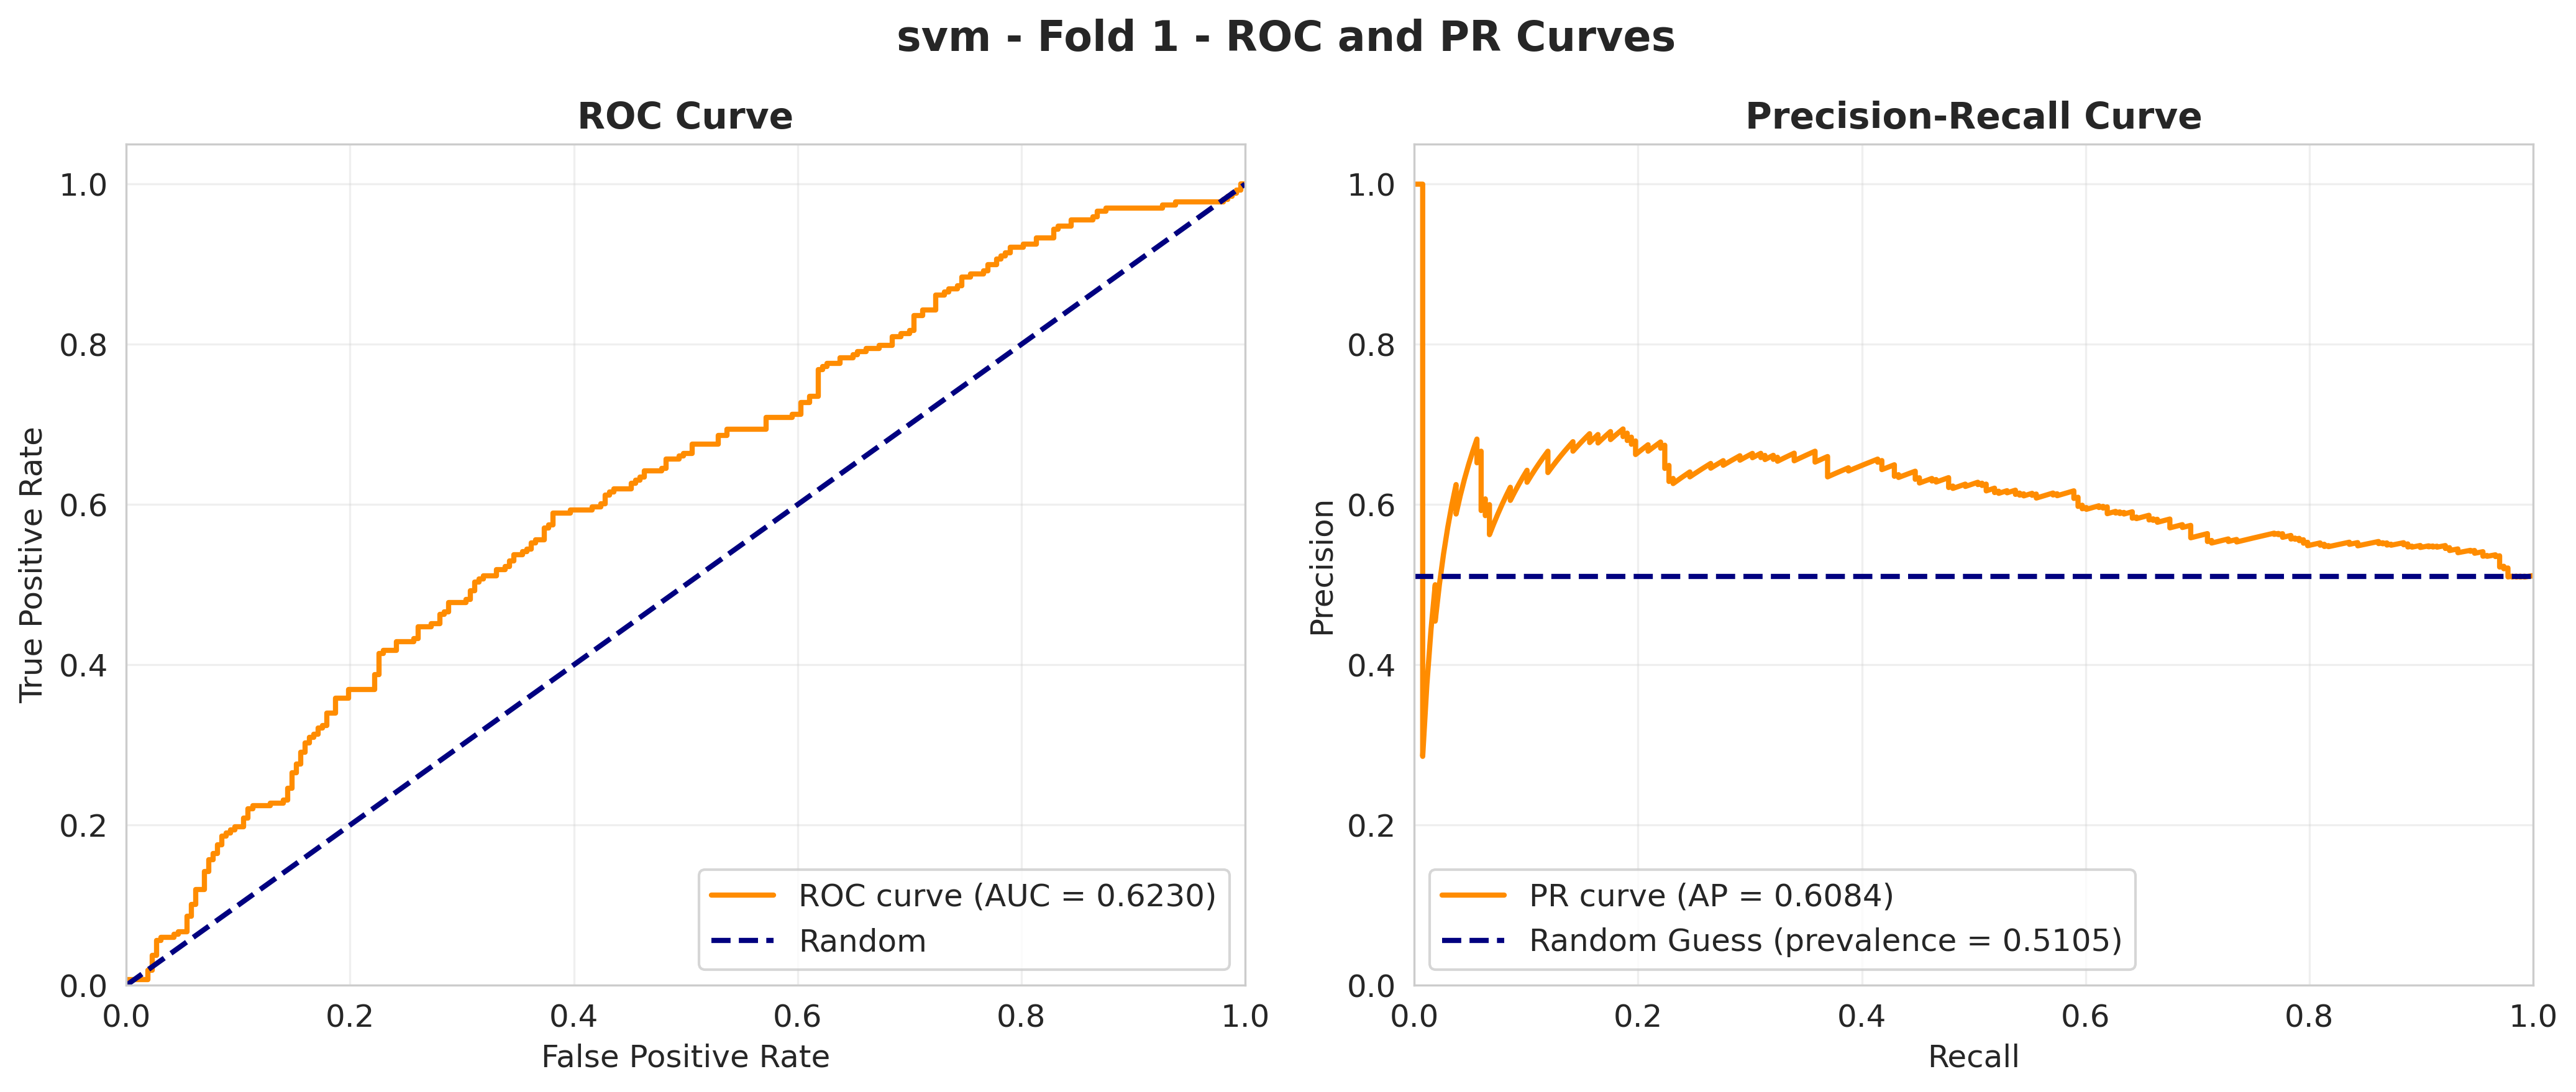

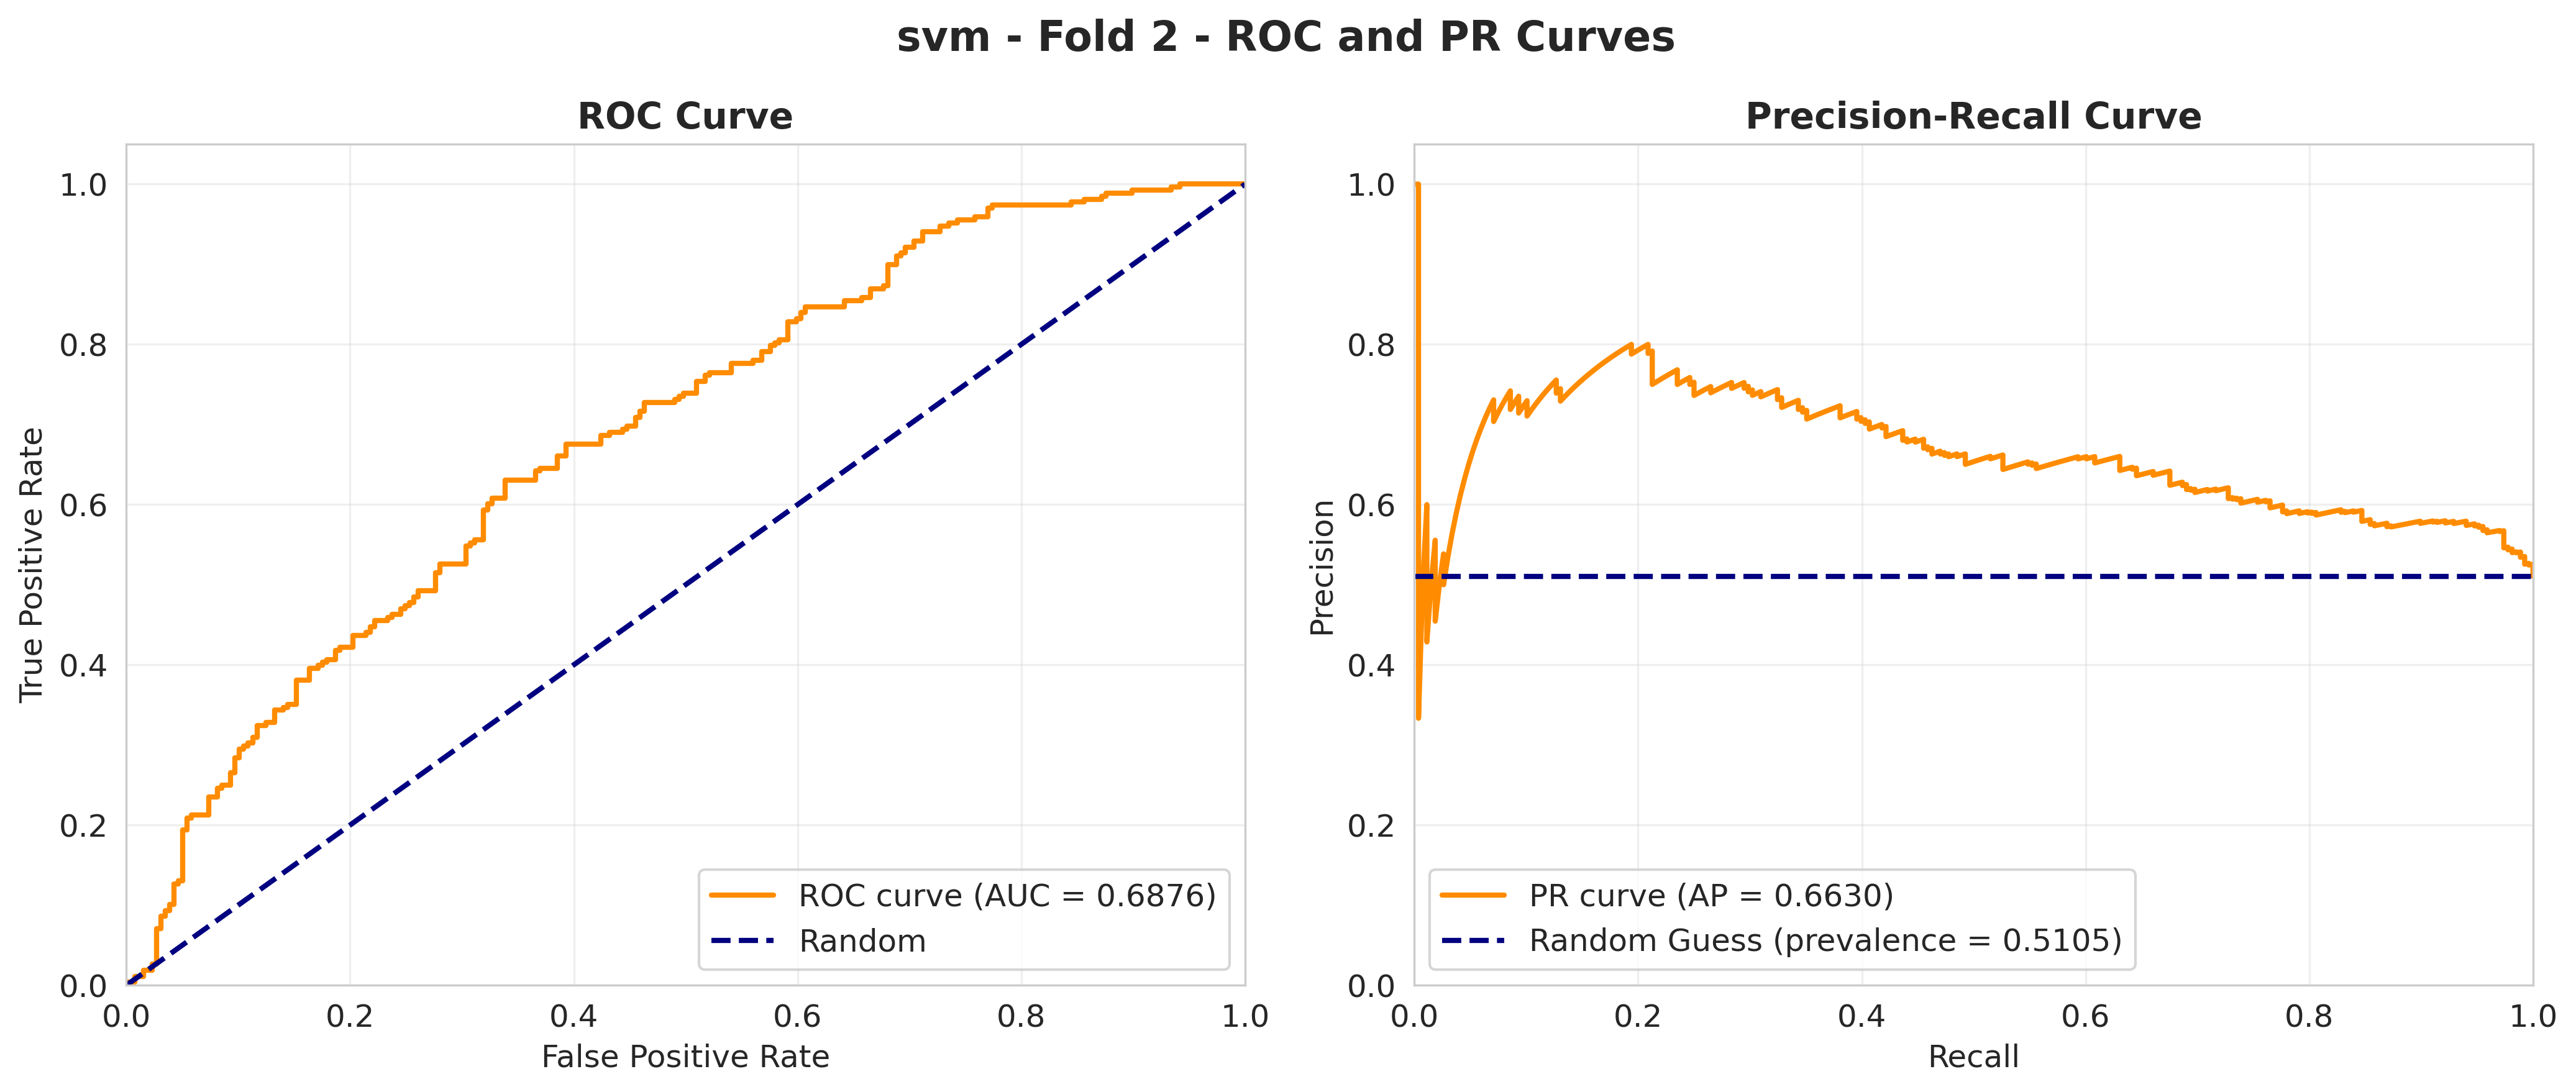

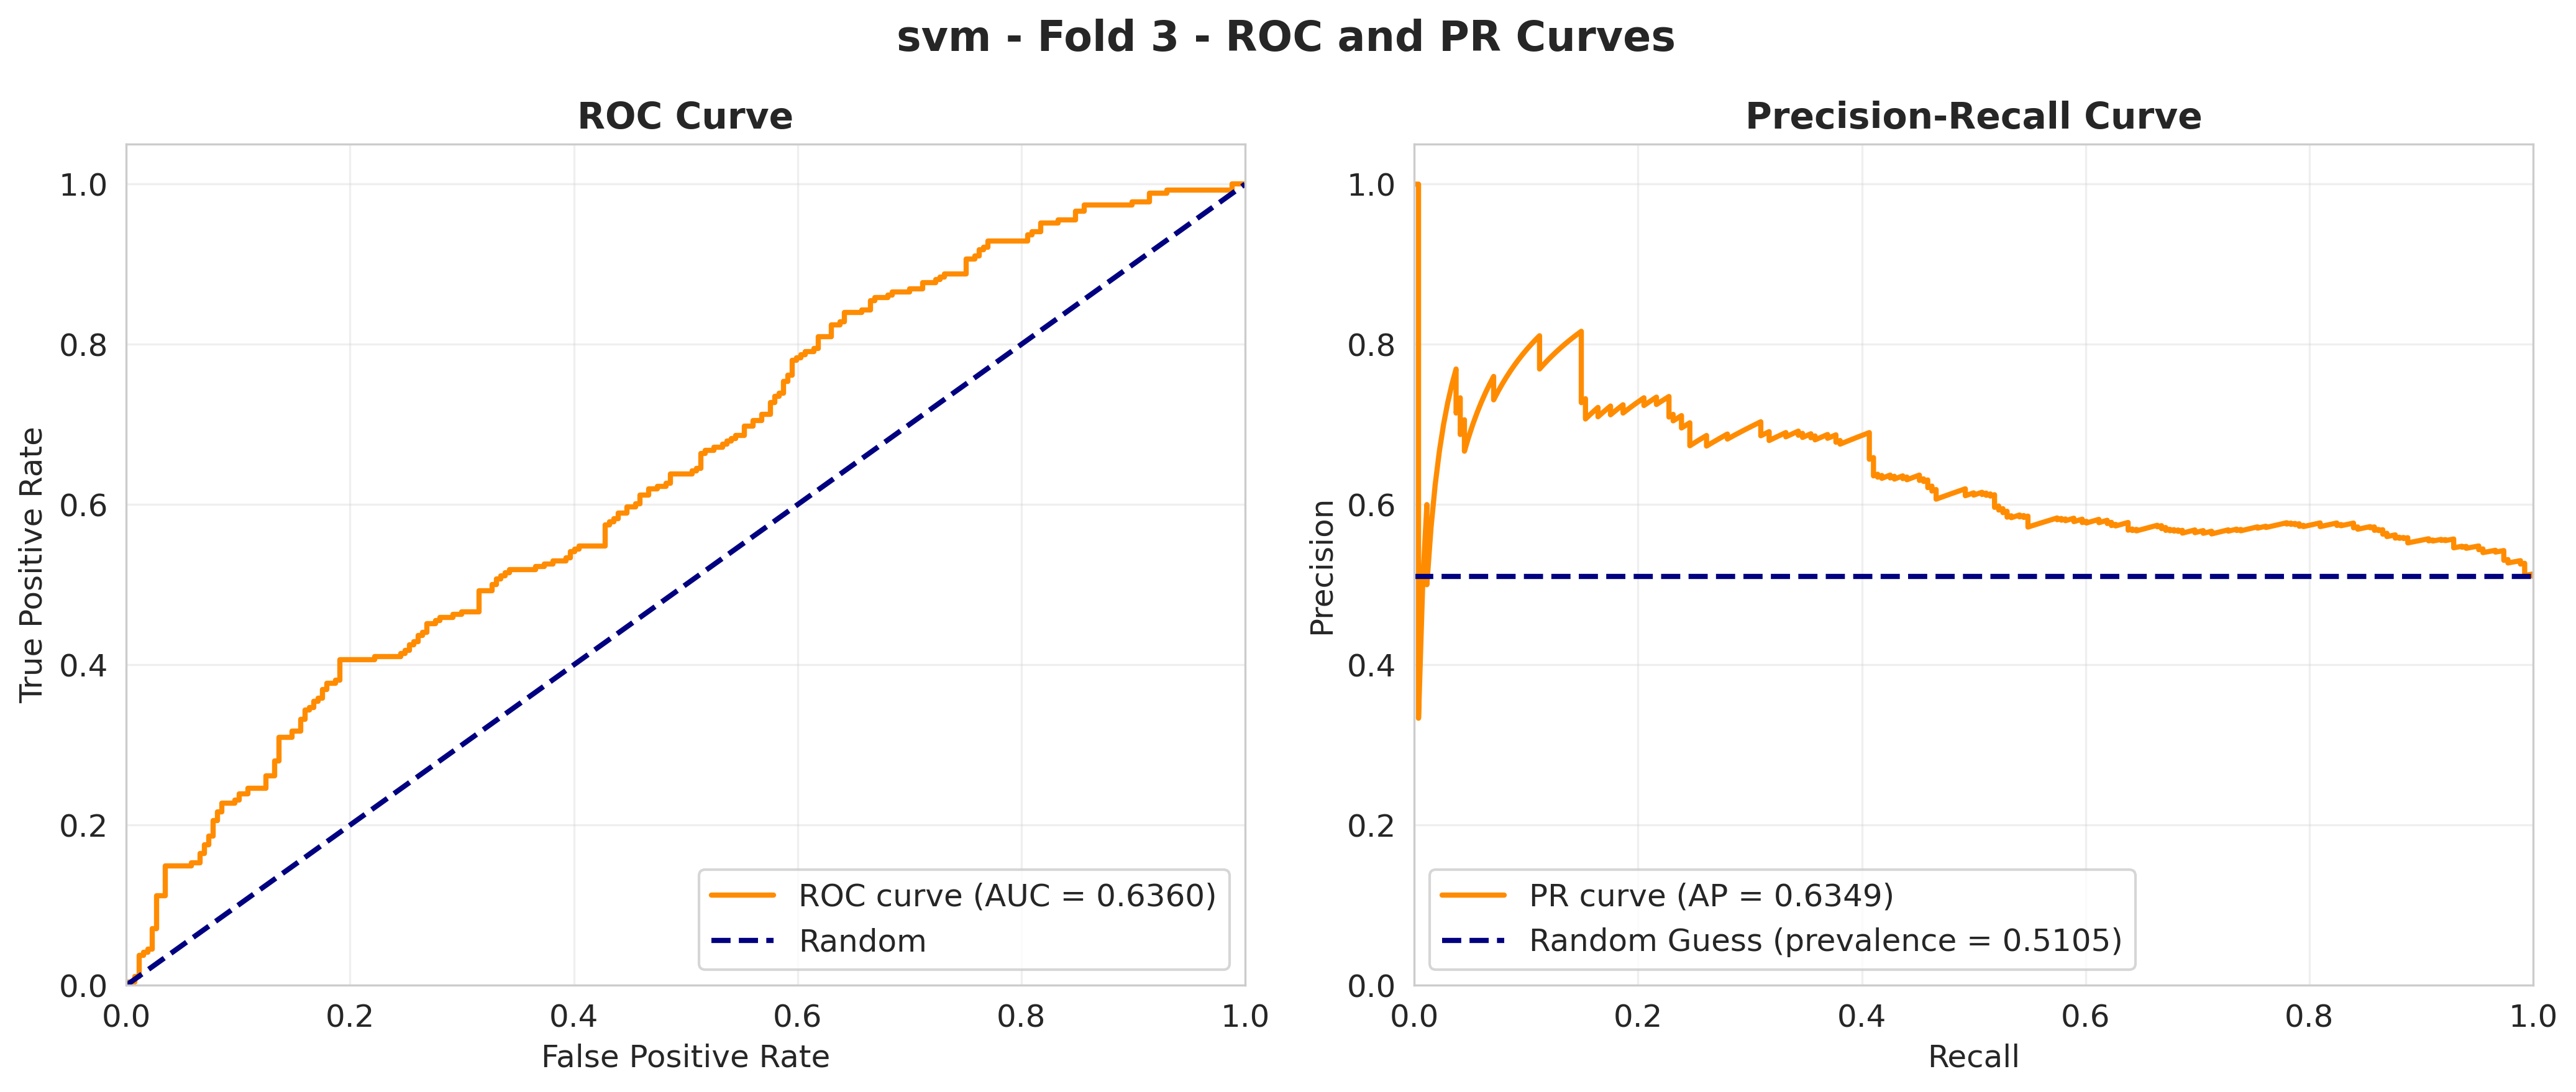

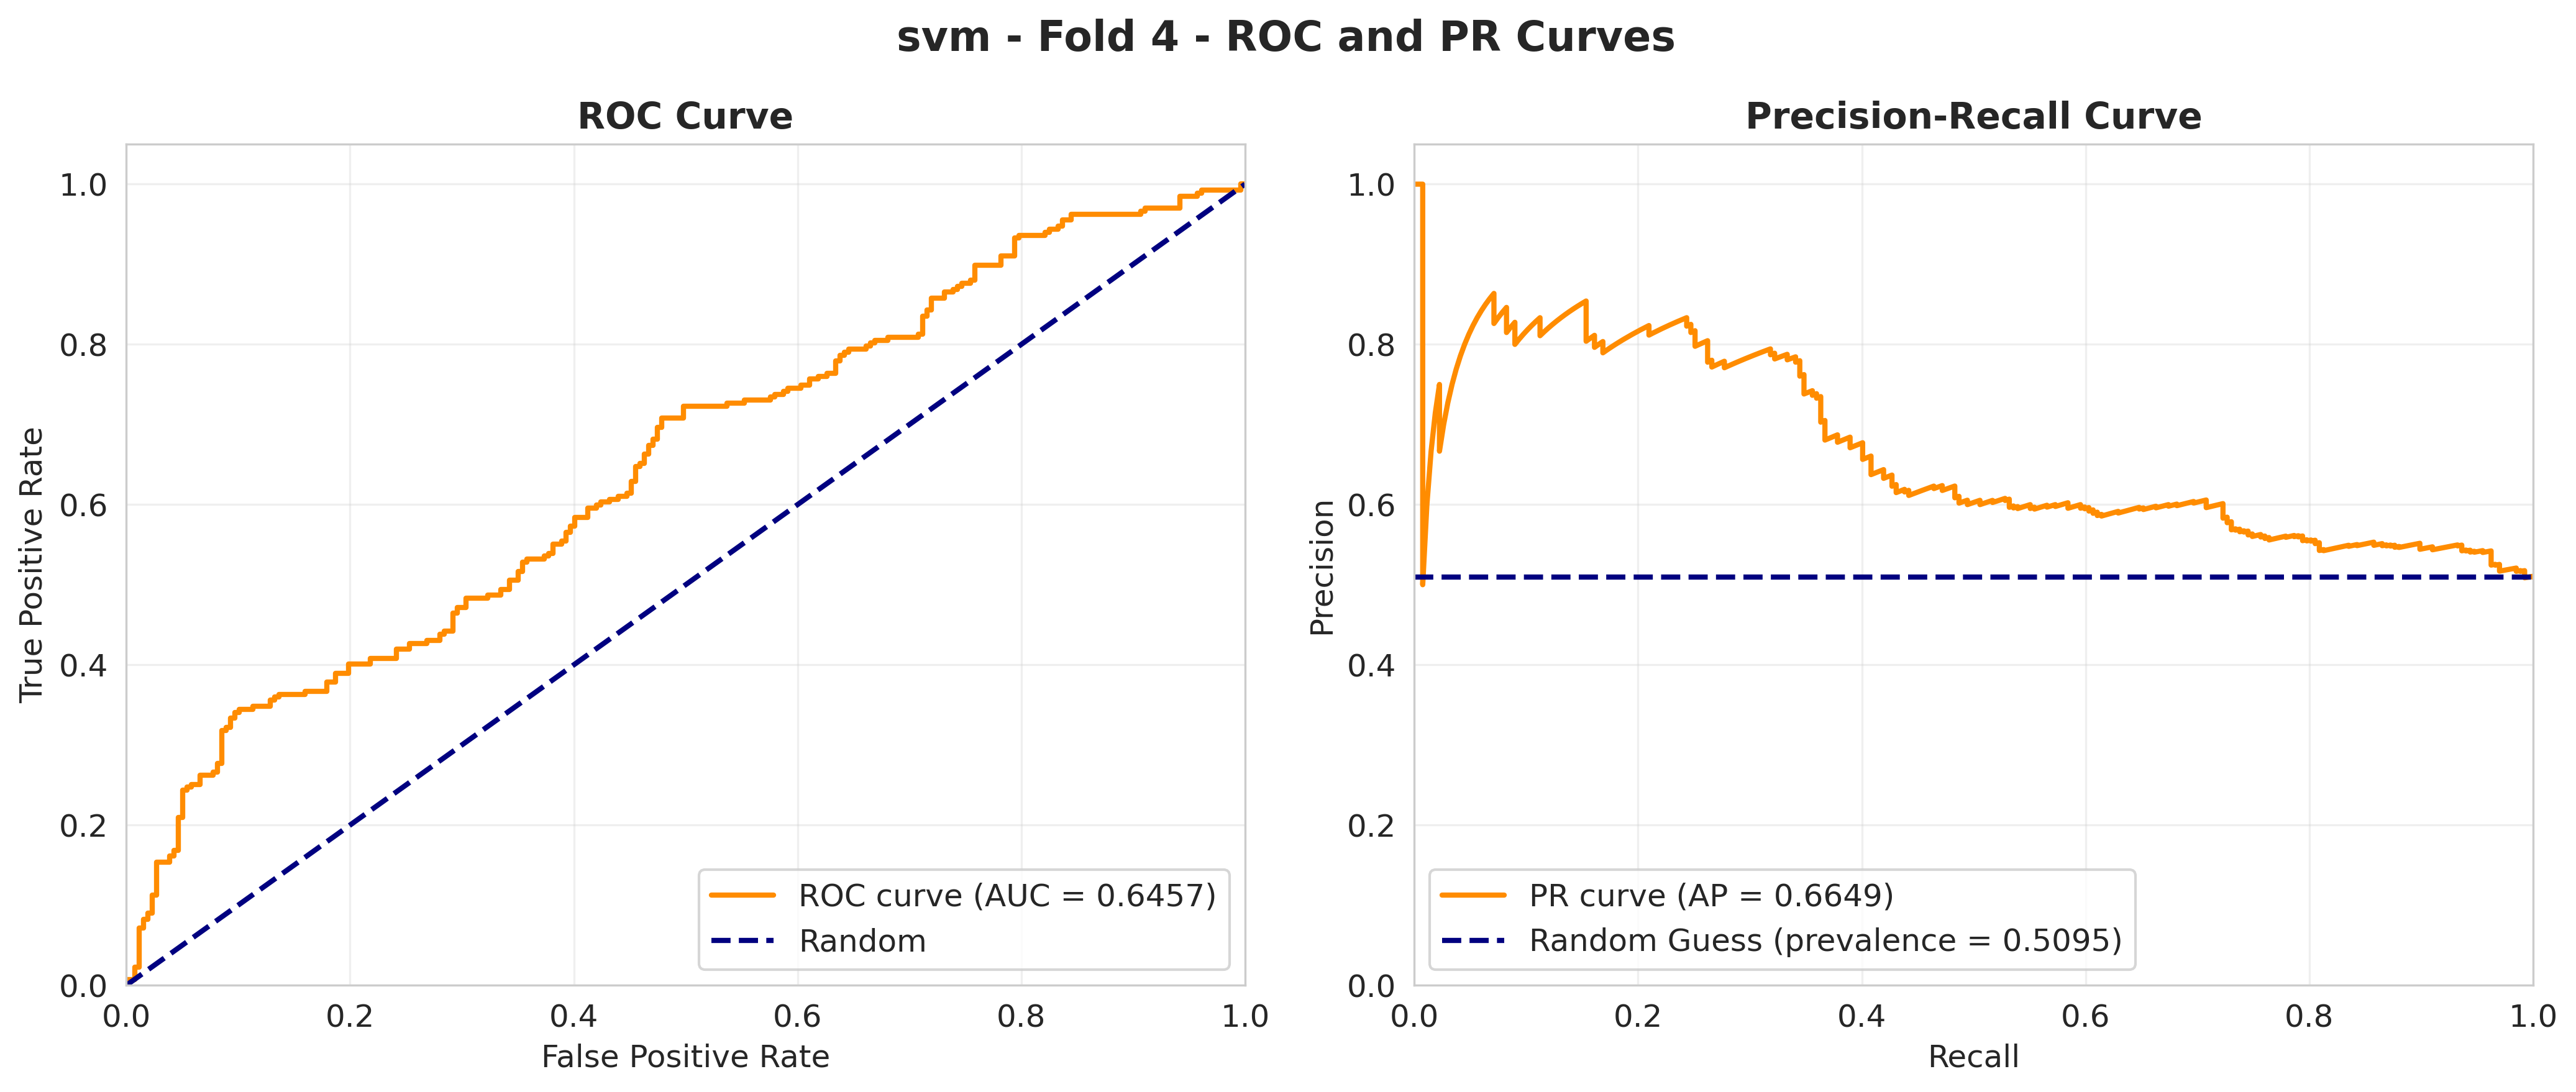

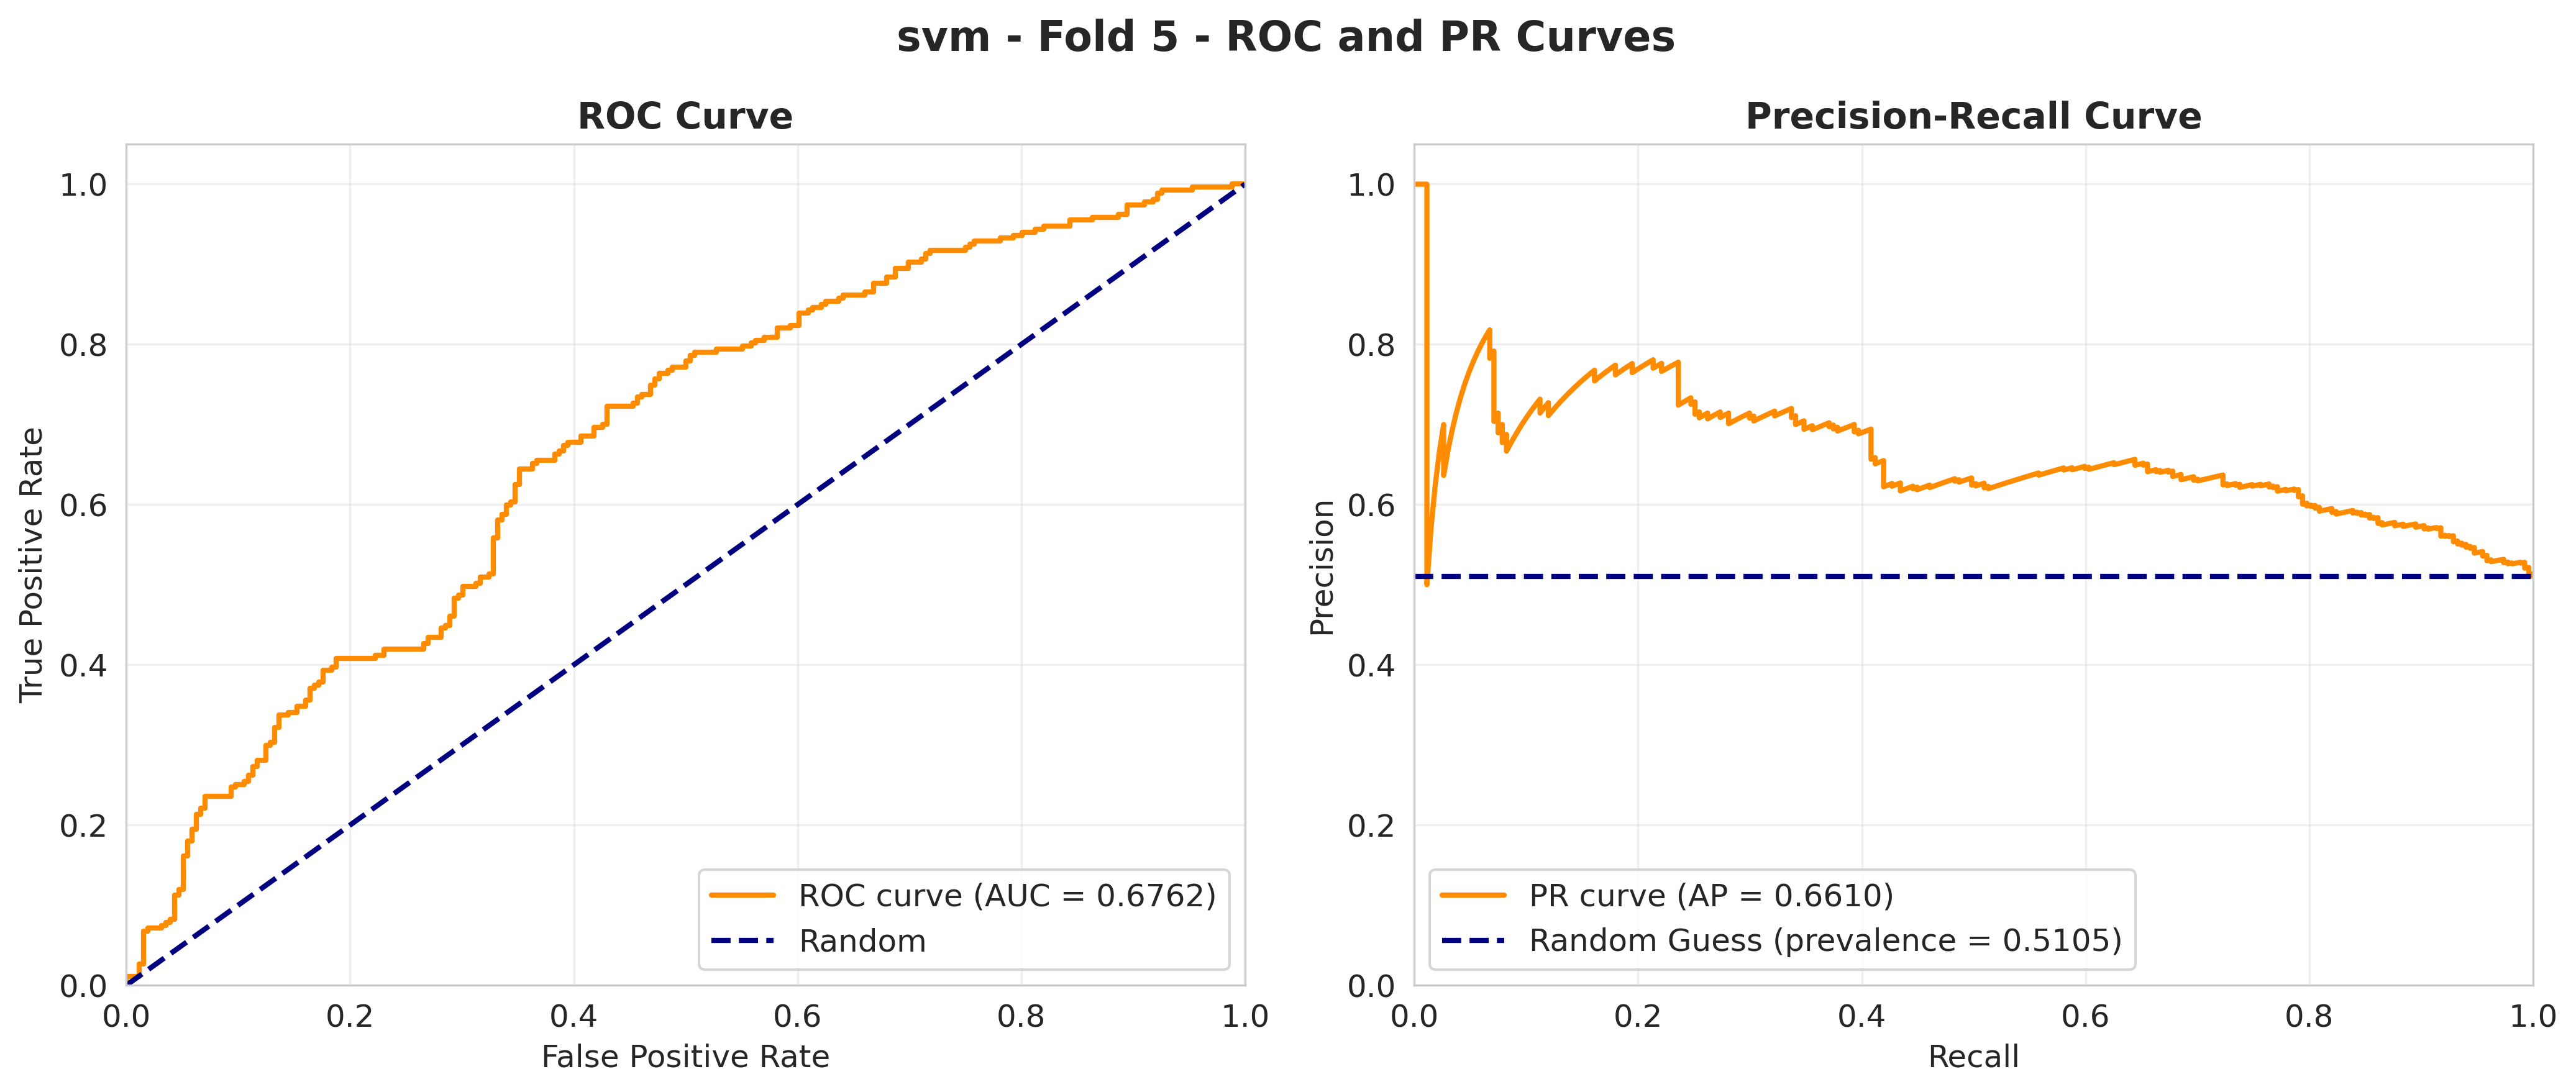

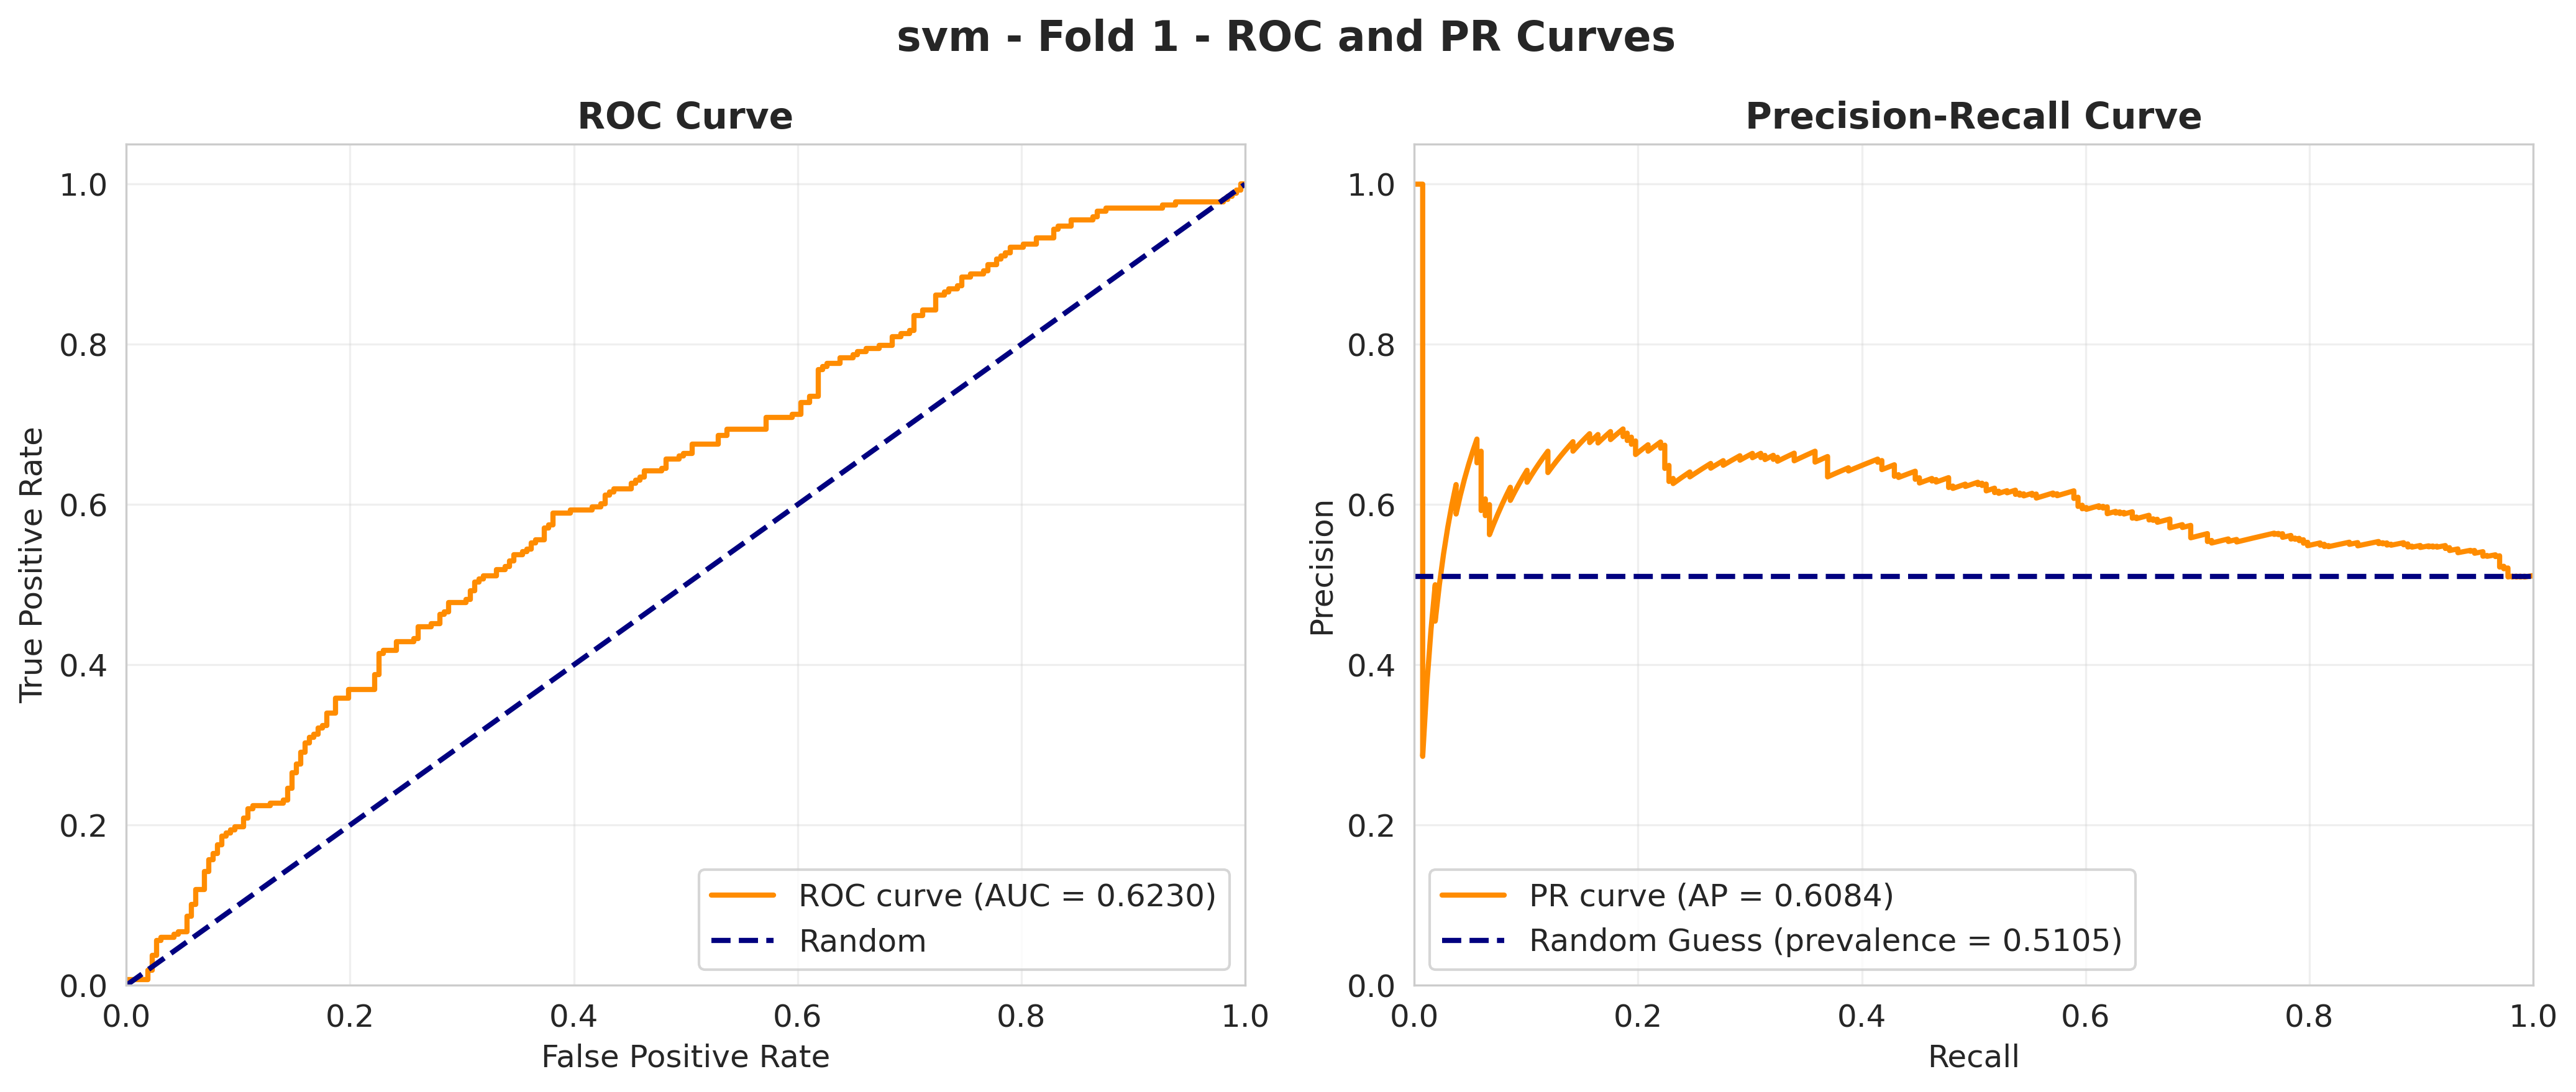

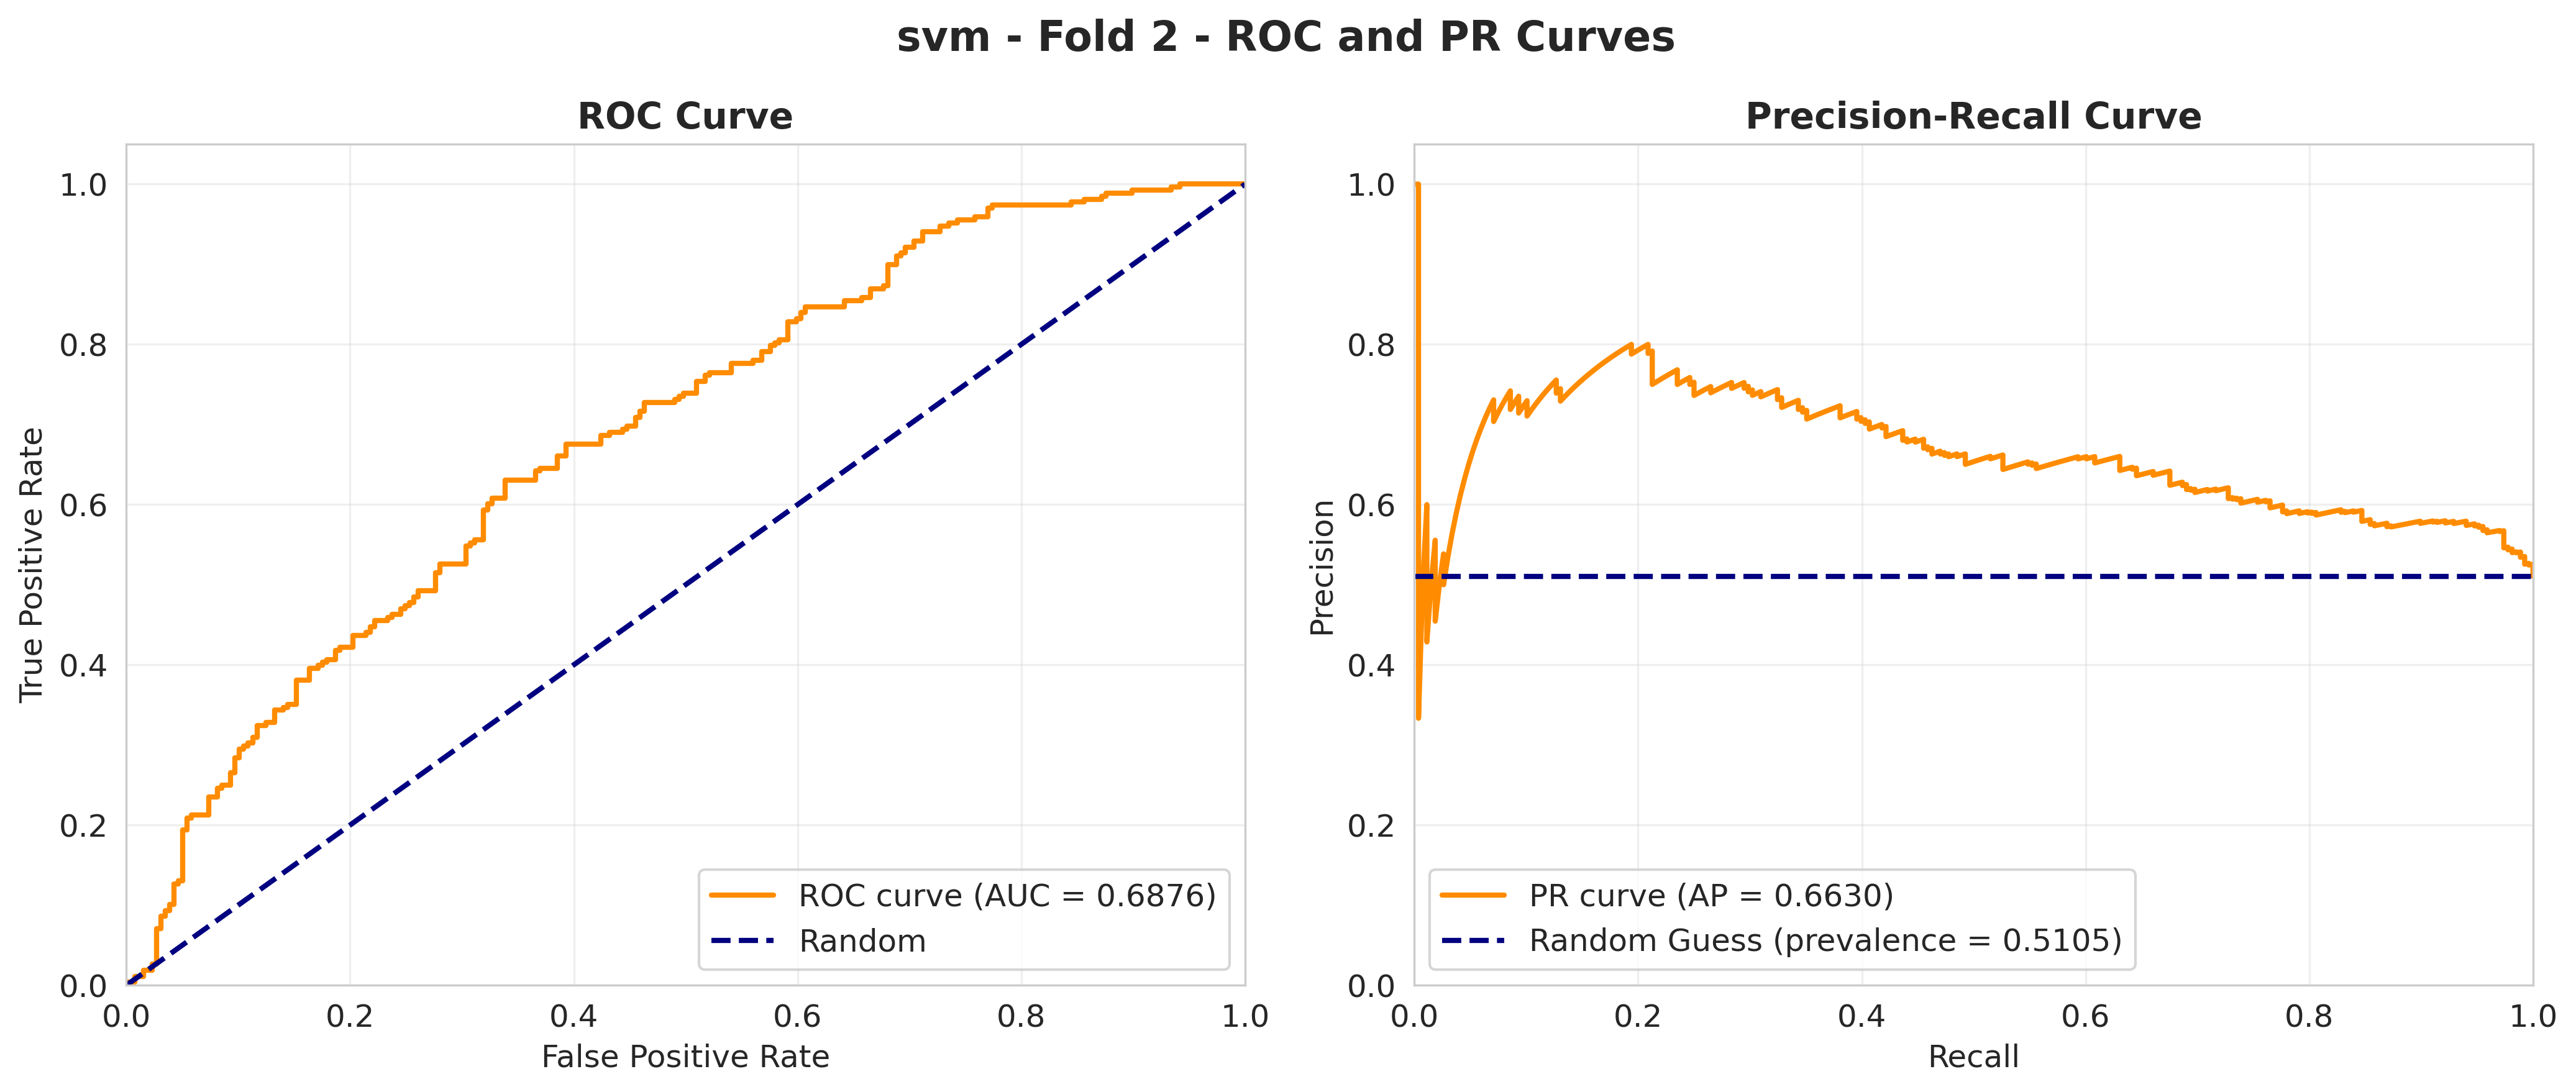

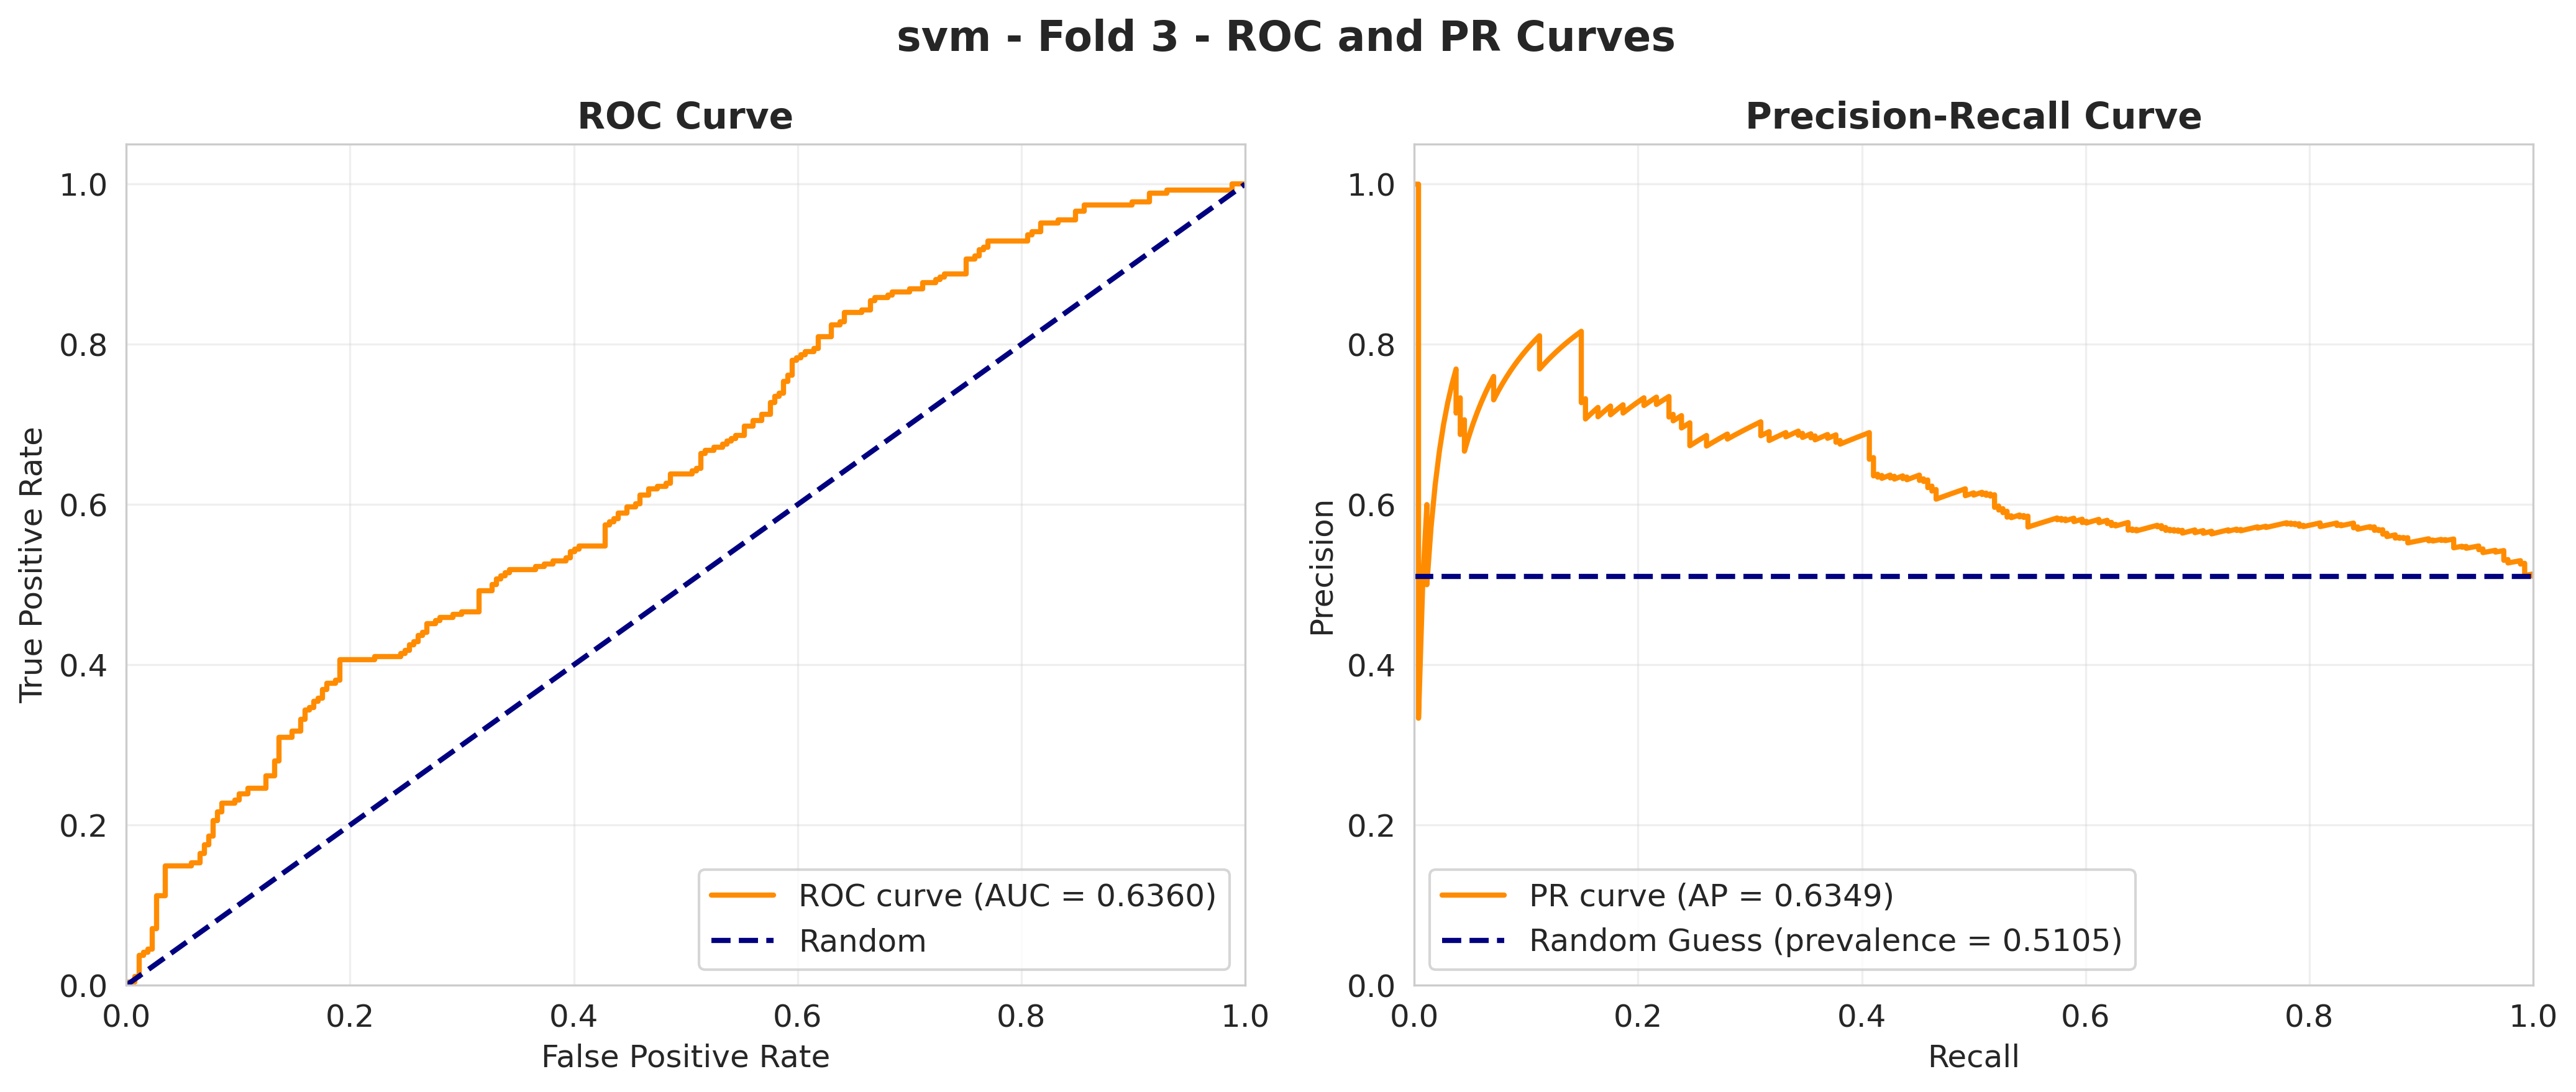

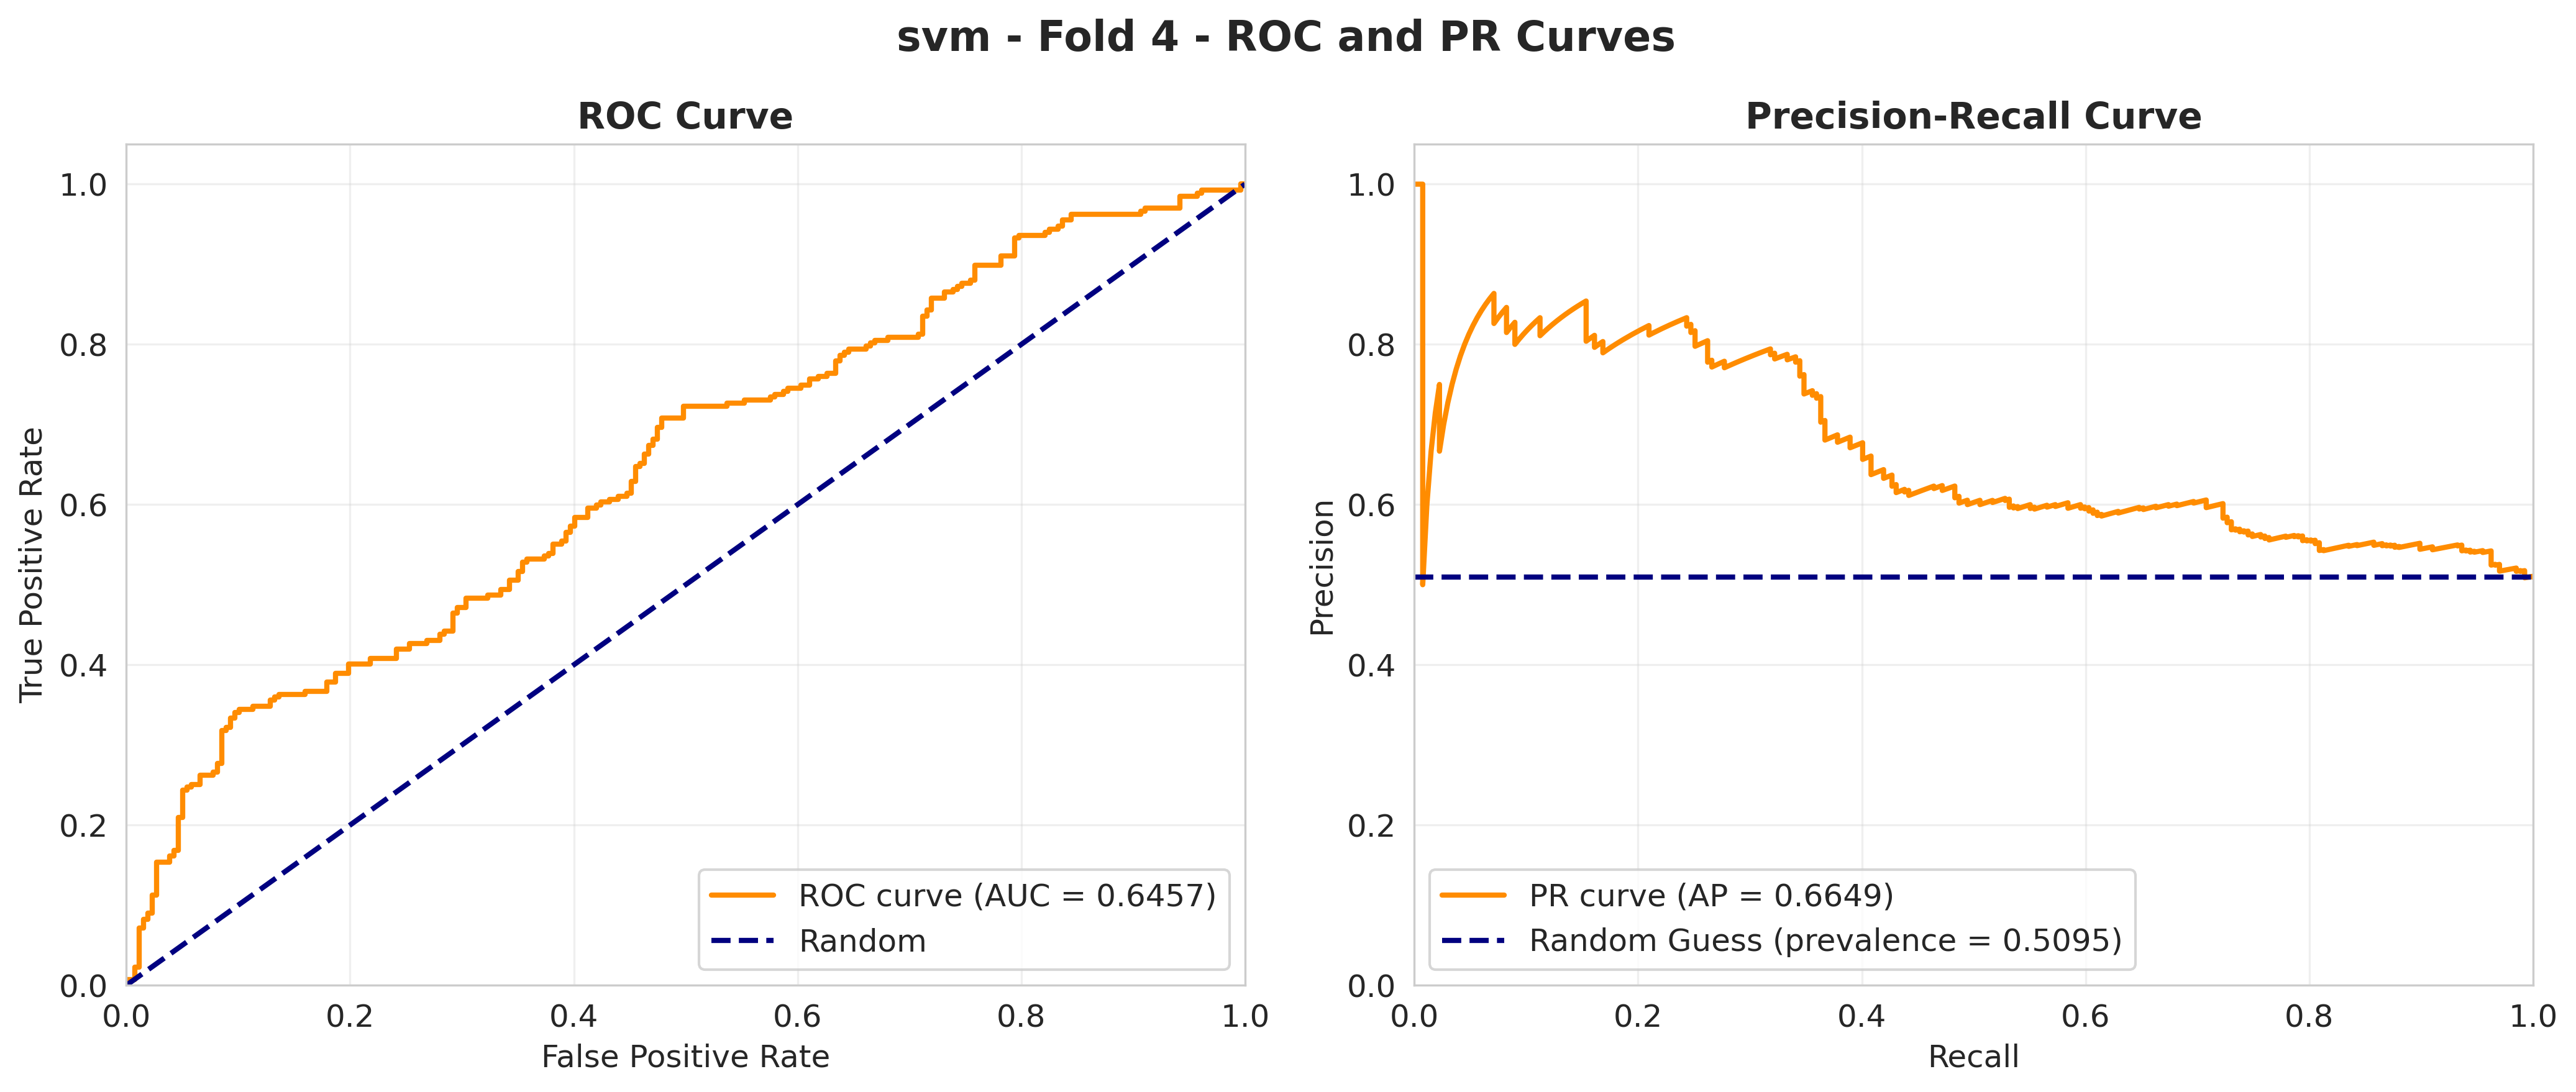

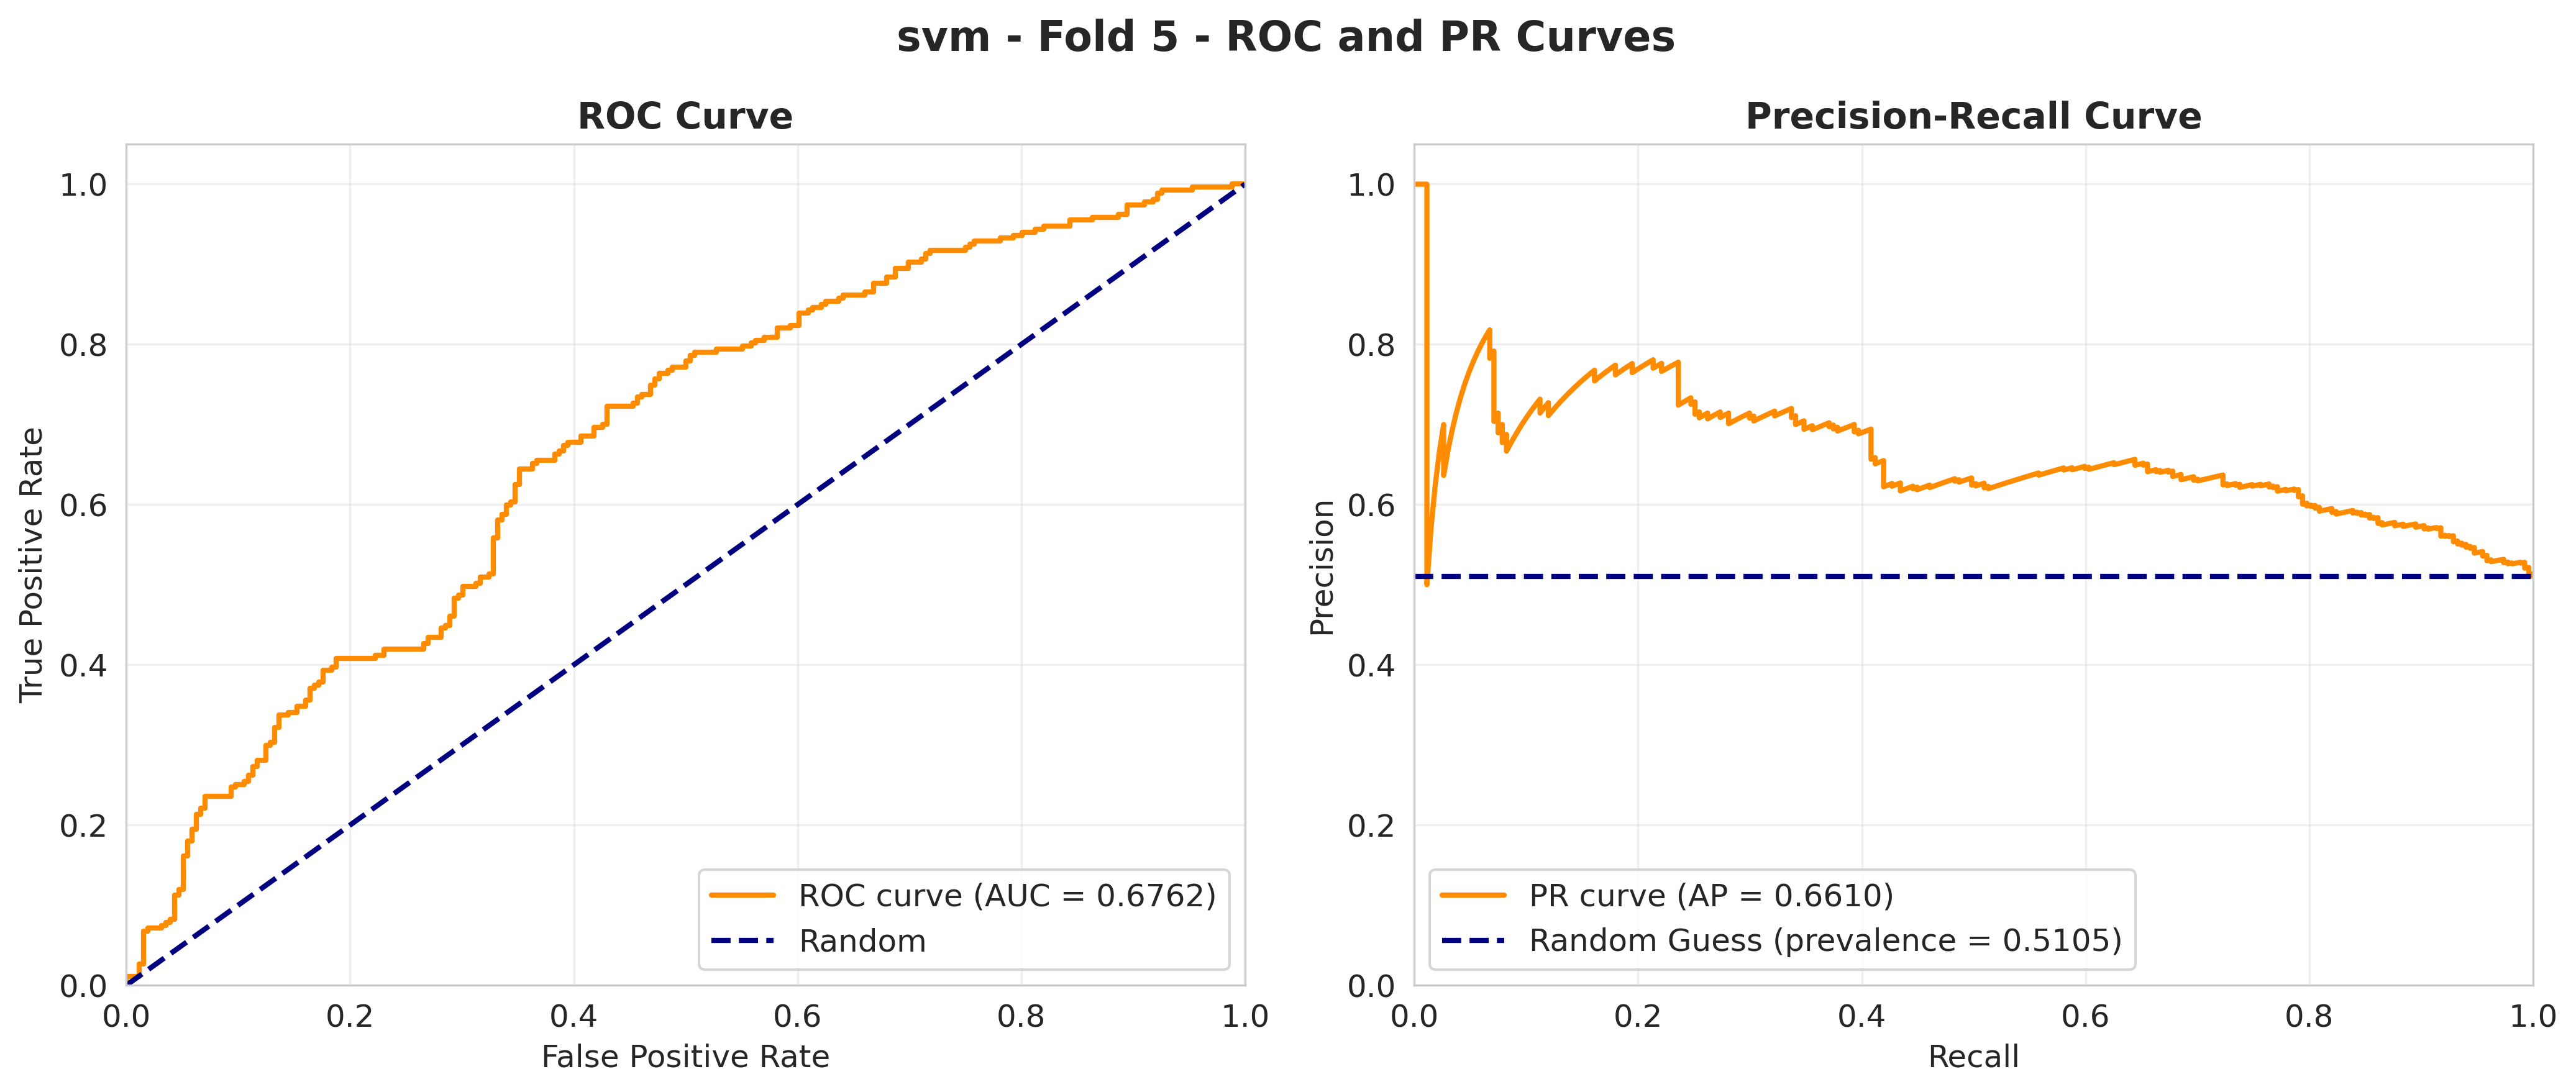

  ✓ Plotting validation metrics across folds...


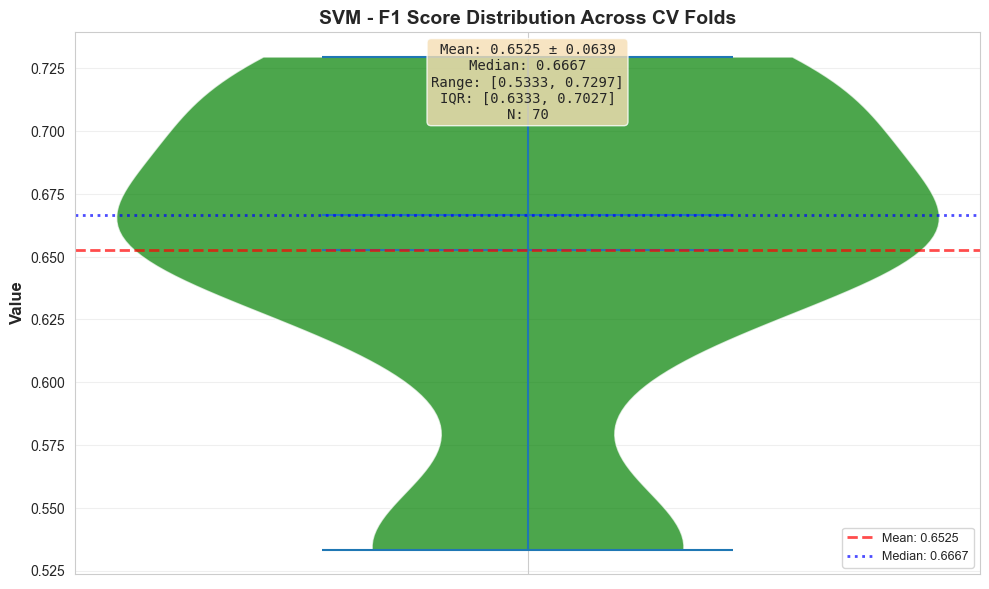

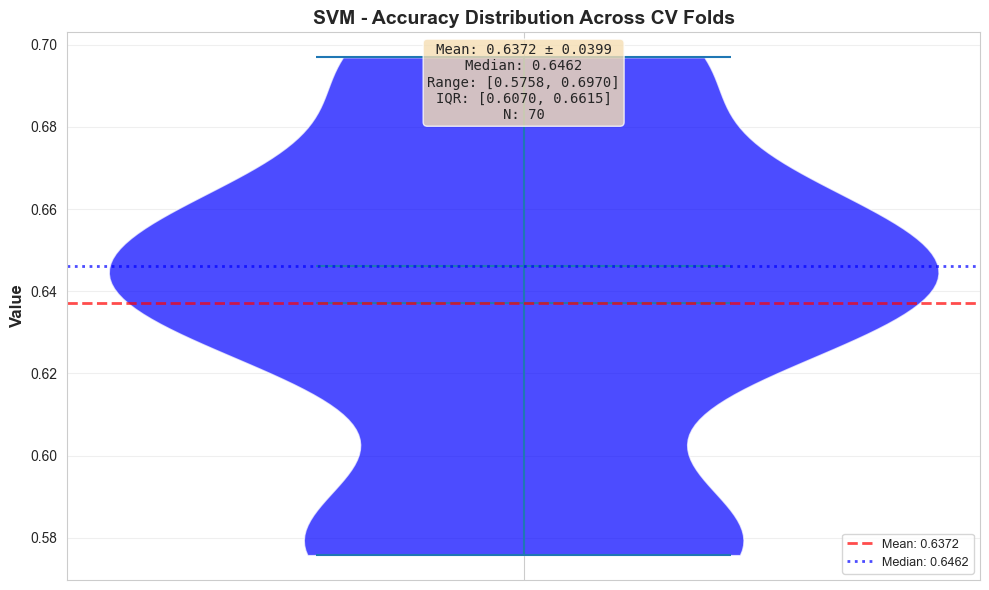

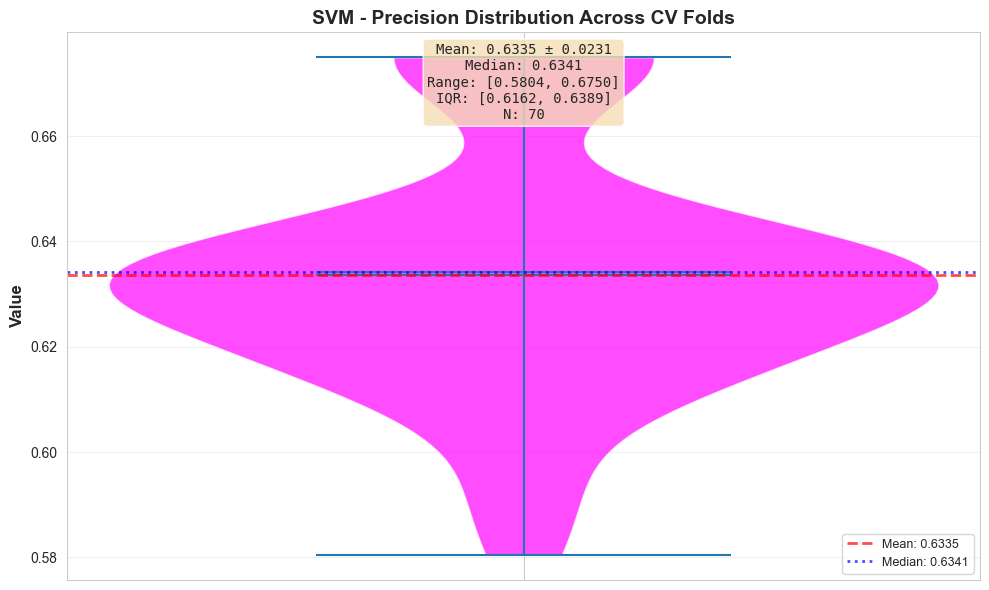

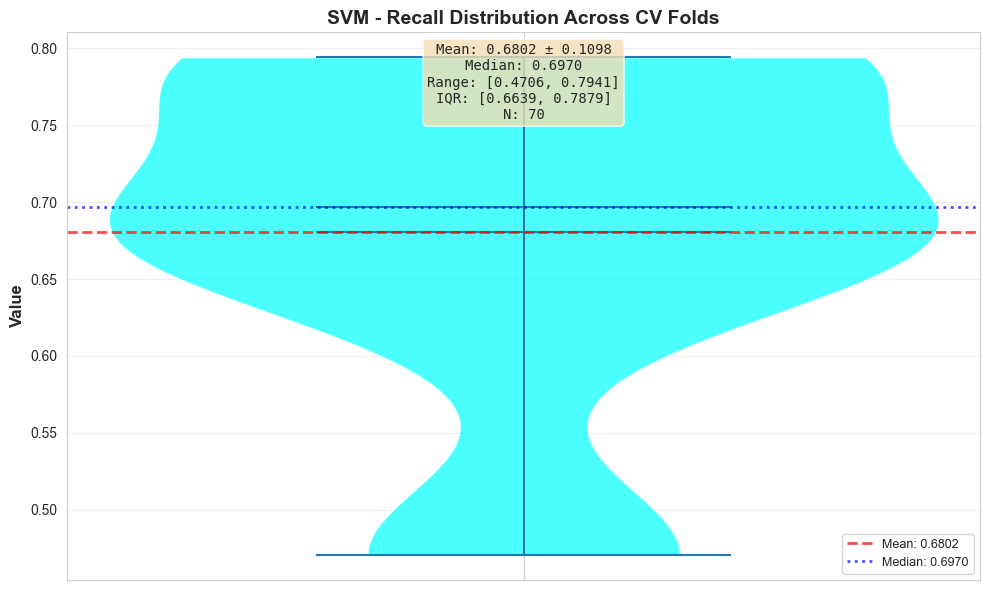

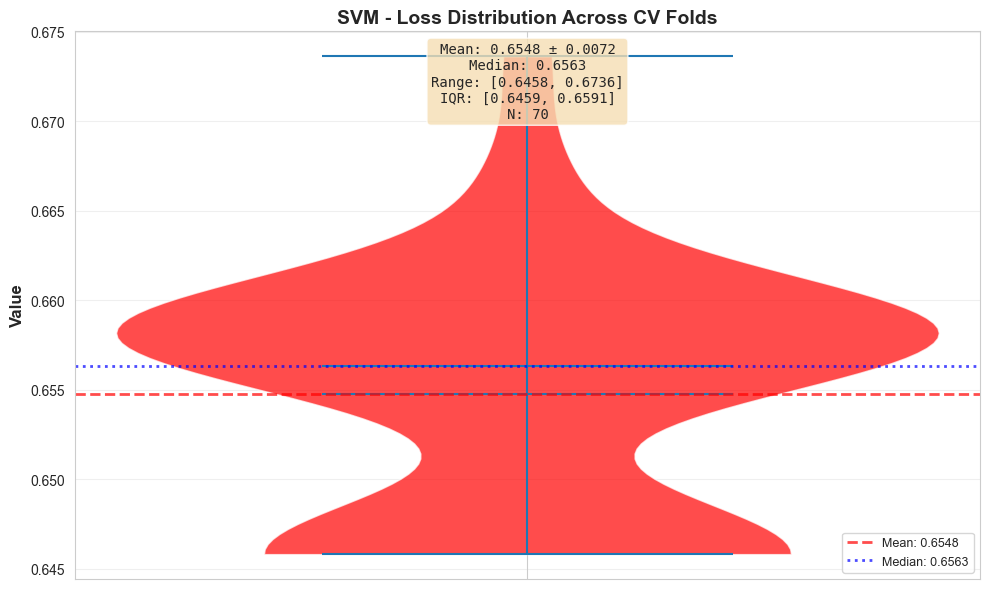

In [13]:
print("\n[5/6] Generating comprehensive visualizations...")
curve_files = find_roc_pr_curve_files(model_id, project_root, MODEL_TYPE_MAPPING)
if curve_files:
    print(f"  ✓ Found ROC/PR curve files")
    display_roc_pr_curve_images(curve_files, model_name, "ROC")
    display_roc_pr_curve_images(curve_files, model_name, "Precision-Recall")
    
if duckdb_metrics and "fold_results" in duckdb_metrics:
    print(f"  ✓ Plotting validation metrics across folds...")
    fig = plot_validation_metrics_across_folds(duckdb_metrics, model_name)
    if fig:
        plt.show()  # Display the plot in notebook


### Step 6/6: Performance Summary

In [14]:
print("\n[6/6] Performance Summary")
print("=" * 70)
    
if results:
    print("\nCross-Validation Results:")
    if "avg_val_f1" in results:
        print(f"  Average Val F1:     {results['avg_val_f1']:.4f} ± {results.get('std_val_f1', 0):.4f}")
    if "avg_val_acc" in results:
        print(f"  Average Val Acc:    {results['avg_val_acc']:.4f} ± {results.get('std_val_acc', 0):.4f}")
    if "fold_results" in results:
        print(f"\nPer-Fold Results:")
        for fold_result in results["fold_results"][:5]:
            fold_num = fold_result.get("fold", "?")
            print(f"  Fold {fold_num}: F1={fold_result.get('val_f1', 0):.4f}, "
                 f"Acc={fold_result.get('val_acc', 0):.4f}")
    
print("\n" + "=" * 70)
print("Analysis complete!")
print("=" * 70)


[6/6] Performance Summary

Cross-Validation Results:
  Average Val F1:     0.6319 ± 0.0265
  Average Val Acc:    0.6068 ± 0.0238

Per-Fold Results:
  Fold 1: F1=0.6087, Acc=0.5886
  Fold 2: F1=0.6526, Acc=0.6248
  Fold 3: F1=0.5993, Acc=0.5771
  Fold 4: F1=0.6288, Acc=0.6011
  Fold 5: F1=0.6702, Acc=0.6424

Analysis complete!


## Execute Analysis

Execute the cells below sequentially to perform the complete analysis. The analysis will:

1. Load results and metrics from multiple data sources
2. Query DuckDB for comprehensive fold-wise statistics
3. Attempt to load MLflow tracking data (if available)
4. Extract and visualize training curves from all folds
5. Generate comprehensive visualizations (ROC/PR curves, validation metrics, analysis plots)
6. Display detailed performance summary with aggregated statistics

**Note**: Execution may take a few moments as it loads data from multiple sources, generates visualizations, and performs statistical aggregations. All plots will be displayed inline in the notebook.
